In [1]:
import ROOT
import time as t
from array import array
import sys
sys.path.insert(0,'.')
import tools
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import Image

Welcome to JupyROOT 6.26/06


In [2]:
# Error bars enabled by default:
ROOT.TH1.SetDefaultSumw2(True)

#Cut manageger helper class.
cuts = tools.FunctionManager()

In [3]:
#Initial setup
Cs_open = ['25220405_165249','25220406_095552','25220406_152607']
CsBa_closed = ['25220225_162922','25220225_171803','25220226_113942',
               '25220226_211622','25220227_214240','25220228_092621']
CsBa_open = ['25220213_171932','25220214_092356','25220215_073923'] # '25220214_084953' missing it seems
_all = [CsBa_open,CsBa_closed, Cs_open] 
# _all = [CsBa_open] # Cs_open MeanBase is much different 

top_dir = '/cvmfs/data/CDMS/RDataFrame_testing/data/'
listHV_source = [item for sublist in _all for item in sublist]
file_source = tools.file_locator(top_dir=top_dir,seriesnumber= listHV_source)

for series in listHV_source:
    file_source.append(f'/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_{series}_v5.root')
        
chanlist=['NFE', 'NFH', 'NFC1', 'NFC2']
tr={}
tr['NFC1']=1
tr['NFH']=2
tr['NFE']=3
tr['NFC2']=4

In [4]:
# Merging analysis files to feed to RDataFrame

#half of them are RQs
nrqs = int(len(file_source)/2)
files = np.array(file_source).reshape(2,nrqs)
for i in range(nrqs):
    print(files[:,i])

chain = {}
chain['rq'] = ROOT.TChain()
chain['rrq'] = ROOT.TChain()

for rq,rrq in zip(files[0],files[1]):
    chain['rq'].Add(f'{rq}?#rqDir/zip1')
    chain['rrq'].Add(f'{rrq}?#rrqDir/zip1')
chain['rrq'].AddFriend(chain['rq'])
df = ROOT.RDataFrame(chain['rrq'])


['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220213_171932.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220213_171932_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220214_092356.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220214_092356_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220215_073923.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220215_073923_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220225_162922.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220225_162922_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220225_171803.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220225_171803_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220226_113942.root'
 '/cvmfs/data/CDMS/RDataFrame_testing/data/rrq/rrq_25220226_113942_v5.root']
['/cvmfs/data/CDMS/RDataFrame_testing/data/OFResults_25220226_211622.root'
 '/cvmfs/data

In [5]:
# call the RDataframe
df = ROOT.RDataFrame(chain['rrq'])

dets = {}

for det, code in tr.items():
    dets[det] = df.Filter(f'trig_ch == {code}',f'trig_ch_{det}')
    #~~~~~~~~~~~~~ TO TEST CACHING USE BELLOW ~~~~~~~~~~~~
    # dets[det] = dets[det].Cache([f'MeanBase_{det}_total','dt_min','dt_before',
    #                              'dt_after',f'OFL_{det}_total','SeriesNumber',
    #                              'timestamp_corr',f'Integral_{det}_total',
    #                              f'OFL_chi2_{det}_total'])


In [58]:
import functools

def check_bounds_general(key, value, bounds):
    return bounds[key][0] < value < bounds[key][1]

bounds = {"a":(0, 3), "b":(1,4)}

check_bounds_specific = functools.partial(check_bounds_general, bounds=bounds)

assert check_bounds_specific("a", .1)
assert not check_bounds_specific("a", 3.4)
assert not check_bounds_specific("b", 1)
assert check_bounds_specific("b", 3.4)

In [63]:
def MB_cut_factory(limit):
    def cut(value):
        return value < limit
    return cut

MB_cut_factory(4)(3)

njit(MB_cut_factory(4))(3)

In [60]:
def check_bounds_specific(key, value):
    bounds = {"a":(0, 3), "b":(1,4)}
    return bounds[key][0] < value < bounds[key][1]

assert check_bounds_specific("a", .1)
assert not check_bounds_specific("a", 3.4)
assert not check_bounds_specific("b", 1)
assert check_bounds_specific("b", 3.4)

In [6]:
cut_def = """
bool %s_%i(unsigned long long x,long double y) {
    bool cond = 1;
    if (x == 25220213171932){
        cond = !(y<1644795814.7650368);
    }
    else if (x == 25220214092356){
        cond = !((y>1644897208.6178577) && (1644897607.070907>y));
    }
    else if (x == 25220215073923) {
        cond = !(y>1644956848.9991407);
    }
    return cond;
}
"""

#Unusual excess time cuts
cuts['global_time_series'] = cut_def
time = {}
for det, code in tr.items():
    time_filter = f'{cuts["global_time_series"]}(SeriesNumber,timestamp_corr)'
    time[det] = dets[det].Filter(time_filter,f'time_{det}')


In [7]:
#dt cut
dt_cut = {}
dt_cut['NFC1'] = 0.01
dt_cut['NFC2'] = 0.01
dt_cut['NFH'] = 0.01
dt_cut['NFE'] = 0.01
dt = {}
for det in tr:
    dt_filter = f'dt_min>{dt_cut[det]}'
    dt[det] = time[det].Filter(dt_filter,f'dt_min_{det}')

In [8]:
#Series separation
MB_series = {}
for det in tr:
    for count, series in enumerate(listHV_source):
        series = int(series)
        series_filter = f'SeriesNumber == {series}'
        MB_series[det,count] = dt[det].Filter(series_filter,f'Seriescut_{det}_{series}')

In [9]:
# nbins = 500
nbins = {}
nbins['NFC1'] = 200
nbins['NFC2'] = 200
nbins['NFH'] = 200
nbins['NFE'] = 200

# xmin = -0.5    
xmin = {}
xmin['NFC1'] = -0.3
xmin['NFC2'] = -0.05
xmin['NFH'] = -0.03
xmin['NFE'] = -0.05

# xmax = 0.5
xmax = {}
xmax['NFC1'] = 0.4
xmax['NFC2'] = 0.3
xmax['NFH'] = 0.02
xmax['NFE'] = 0.3
nhist = nrqs
hist_rdf = tools.hist_builder(nbins,xmin,xmax,tr,nhist,hist_title = 'MB')         
        
        
# Book MB histograms 
hists ={}
for count, series in enumerate(listHV_source):
    series = int(series)
    hists[count] = {}
    for det in tr:
        hists[count][det] = MB_series[det,count].Histo1D(hist_rdf[count][det],f'MeanBase_{det}_total')

In [10]:
#### FOR ANDREA:
#### I guess you need the procedure below. RunGraphs is introduced in ROOT 6.24, and that's not available in the CDMS kernels.
#### Maybe the easiest way to test is to make a venv and use miniconda to install ROOT 6.26.
#### https://root-forum.cern.ch/t/installing-root-with-conda/39787/2


# hists_list = []
# for value in hists.values():
#     for hist in value.values():
#         hists_list.append(hist)
# RunGraphs = ROOT.RDF.Experimental.Distributed.RunGraphs
# RunGraphs(hists_list)

(<cppyy.gbl.TCanvas object at 0x55faa50bc550>,
 {'NFC1': <cppyy.gbl.TLegend object at 0x55faa74f2a50>,
  'NFH': <cppyy.gbl.TLegend object at 0x55faa71a77d0>,
  'NFE': <cppyy.gbl.TLegend object at 0x55faa79c7c00>,
  'NFC2': <cppyy.gbl.TLegend object at 0x55faa73696d0>},
 {'NFC1': <cppyy.gbl.THStack object at 0x55faa7ff8070>,
  'NFH': <cppyy.gbl.THStack object at 0x55faa7237870>,
  'NFE': <cppyy.gbl.THStack object at 0x55faa713d030>,
  'NFC2': <cppyy.gbl.THStack object at 0x55faa7140580>})

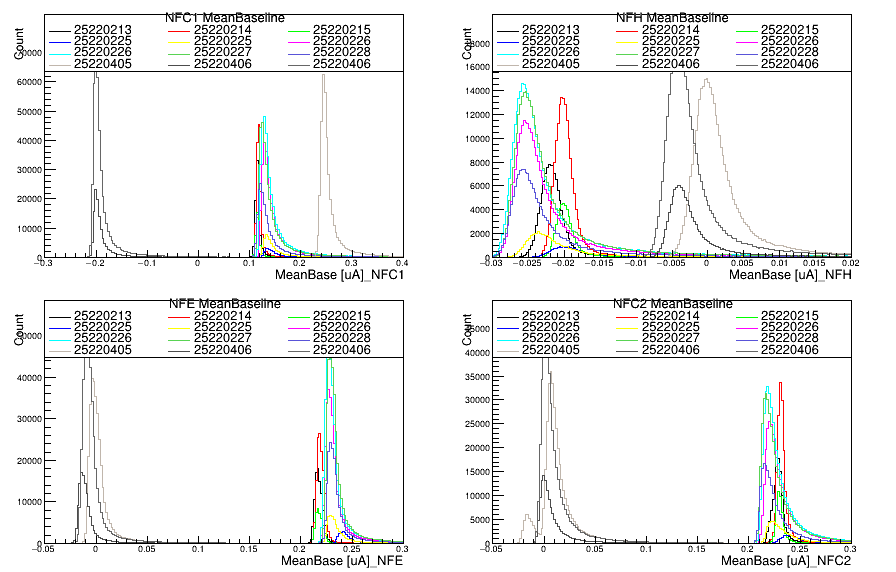

In [11]:
# Look into MB histograms
xaxis_label = 'MeanBase [uA]'
yaxis_label = 'Count'
legend_spec = {}
legend_spec['header'] = 'MeanBaseline'
legend_spec['loc'] = [0.1,0.75,0.9,0.95]
legend_spec['ncolumn'] =3
for count, series in enumerate(listHV_source):
    series = series.split('_')
    legend_spec[count] = f'{str(series[0])}'
    
tools.plothelper(tr,hists,setlog={'x':False,'y':False}, xaxis_label = xaxis_label,draw_option = 'nostack,hist',
           yaxis_label = yaxis_label,legend_spec= legend_spec)

In [12]:
# First fit to MB plots. I'll sue the output to run the to urn the fit again
hist_stack = {}
fit ={}
MB_cut_values = {}
axisx_label = 'MB [uA]'
axisy_label = 'Count'
for det in tr:
    hist_stack[det] = ROOT.THStack(f'{det}','MB')
    print(det)
    for i in range(nrqs):
        fit[i,det] = ROOT.TF1(f"{i}_{det}","gaus(0)", xmin[det],xmax[det]);
        fit[i,det].SetLineColor(4)
        fit[i,det].SetParameters(1.,0.,0.1);
        
        sys.stdout.flush() 
        t.sleep(0.1)
        hists[i][det].Fit(f"{i}_{det}",'RMq')
        
        hists[i][det].SetTitle(f'{listHV_source[i]}-{det}')
        axisx = hists[i][det].GetXaxis()
        axisx.SetTitle(axisx_label)
        axisx.SetTitleOffset(.8);
        axisx.SetTitleSize(.05);
        axisy = hists[i][det].GetYaxis()
        axisy.SetTitle(axisy_label)
        axisy.SetTitleOffset(.8);
        axisy.SetTitleSize(.05);
        hist_stack[det].Add(hists[i][det].GetPtr())
        mean = fit[i,det].GetParameter(1)
        sig = fit[i,det].GetParameter(2)
        MB_cut_values[i,det] = {'mean': mean,
                                'sig': sig,
                                'lower_3sig_cut': mean-3*sig,
                                'upper_3sig_cut': mean+3*sig}

NFC1
NFH
NFE
NFC2


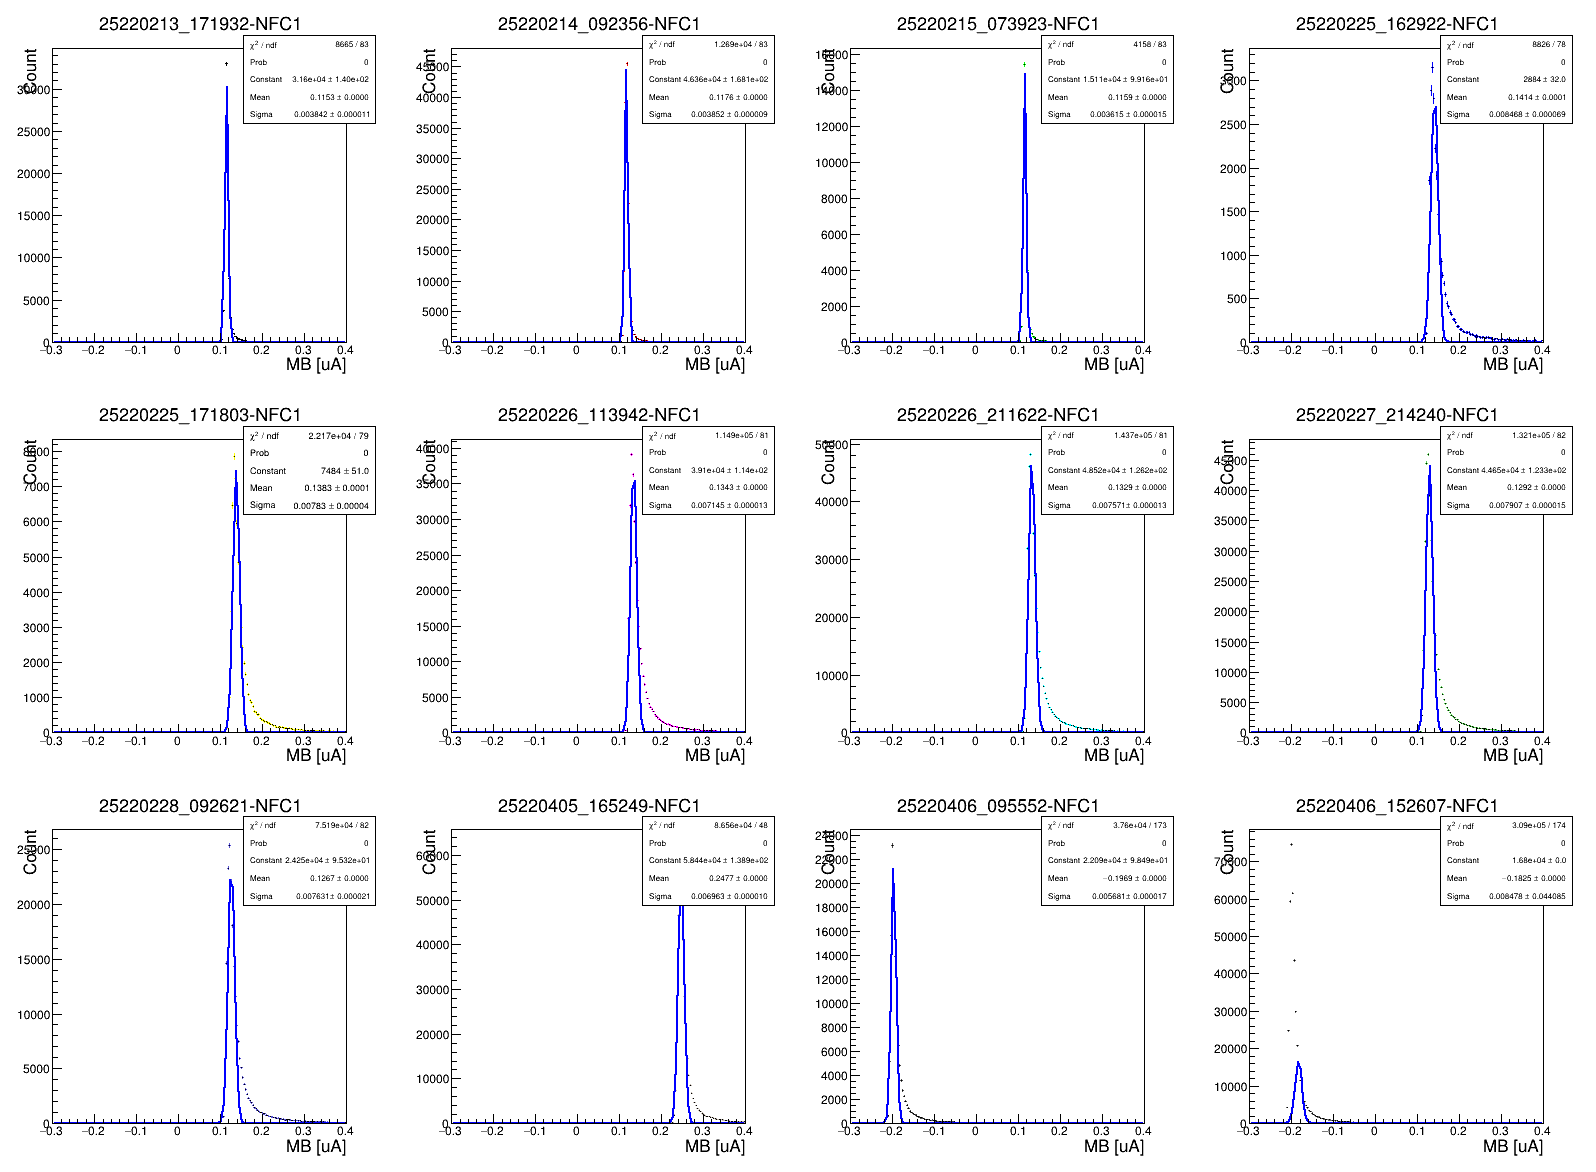

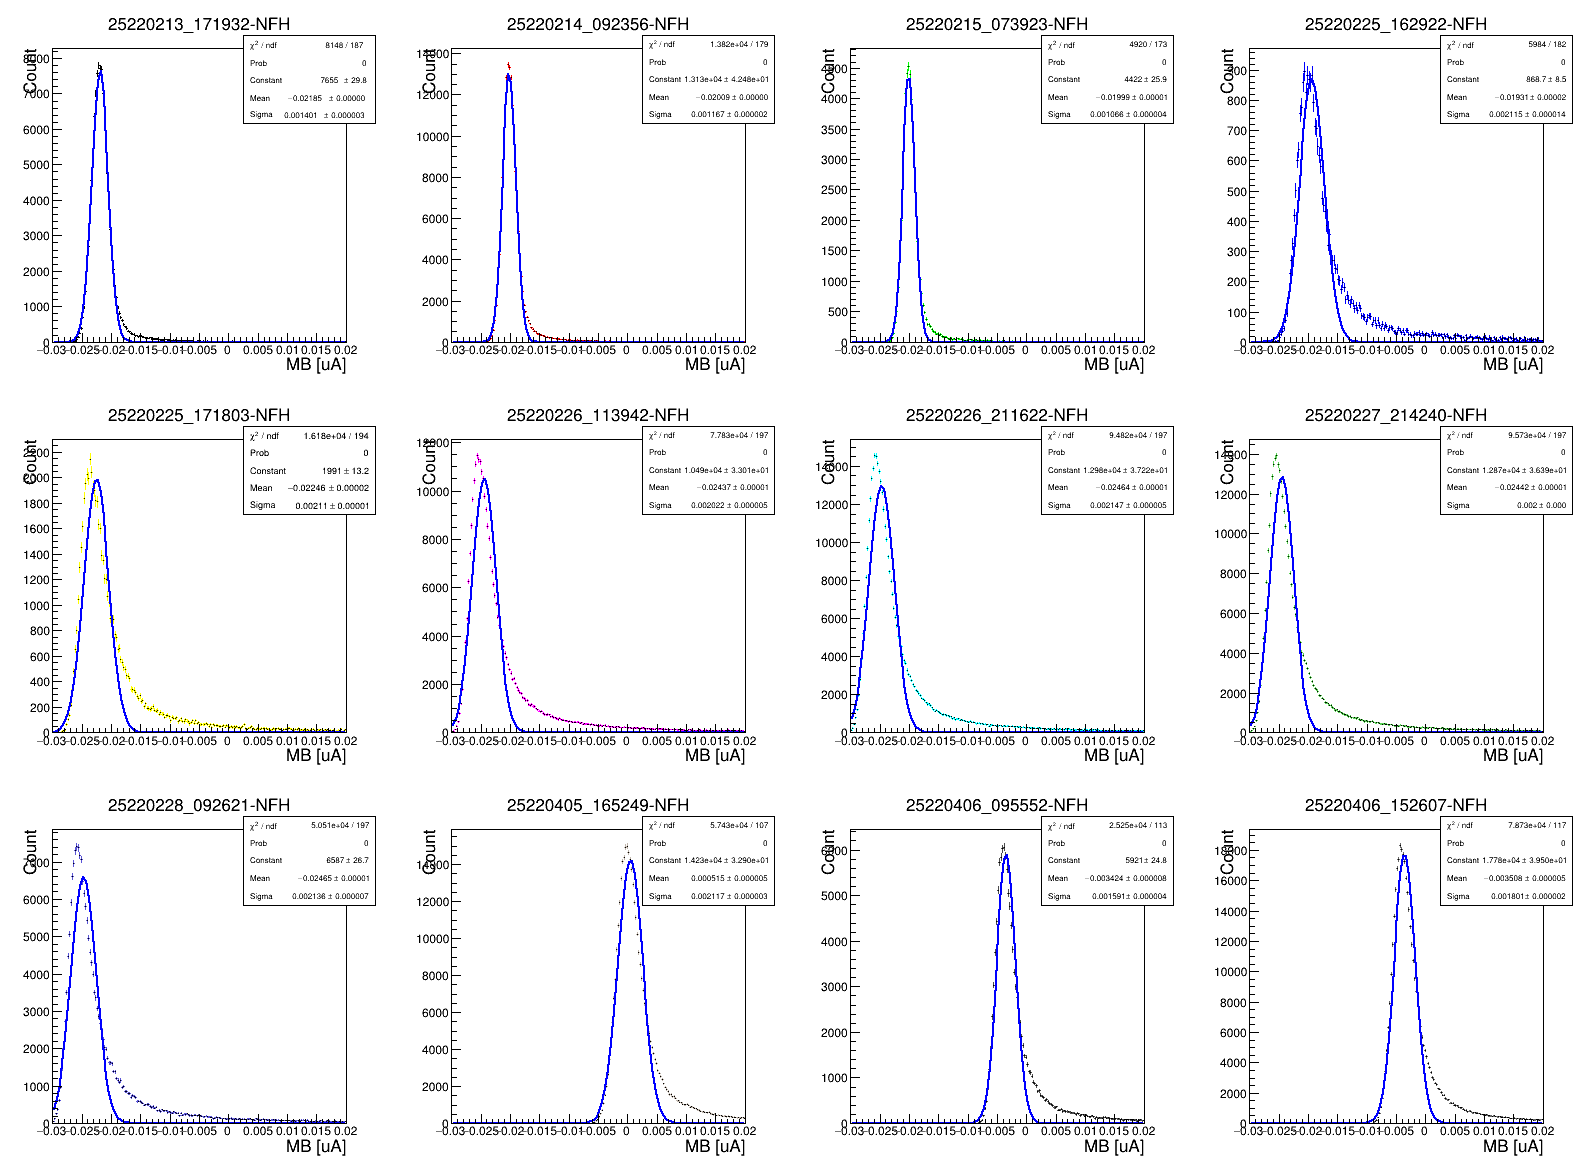

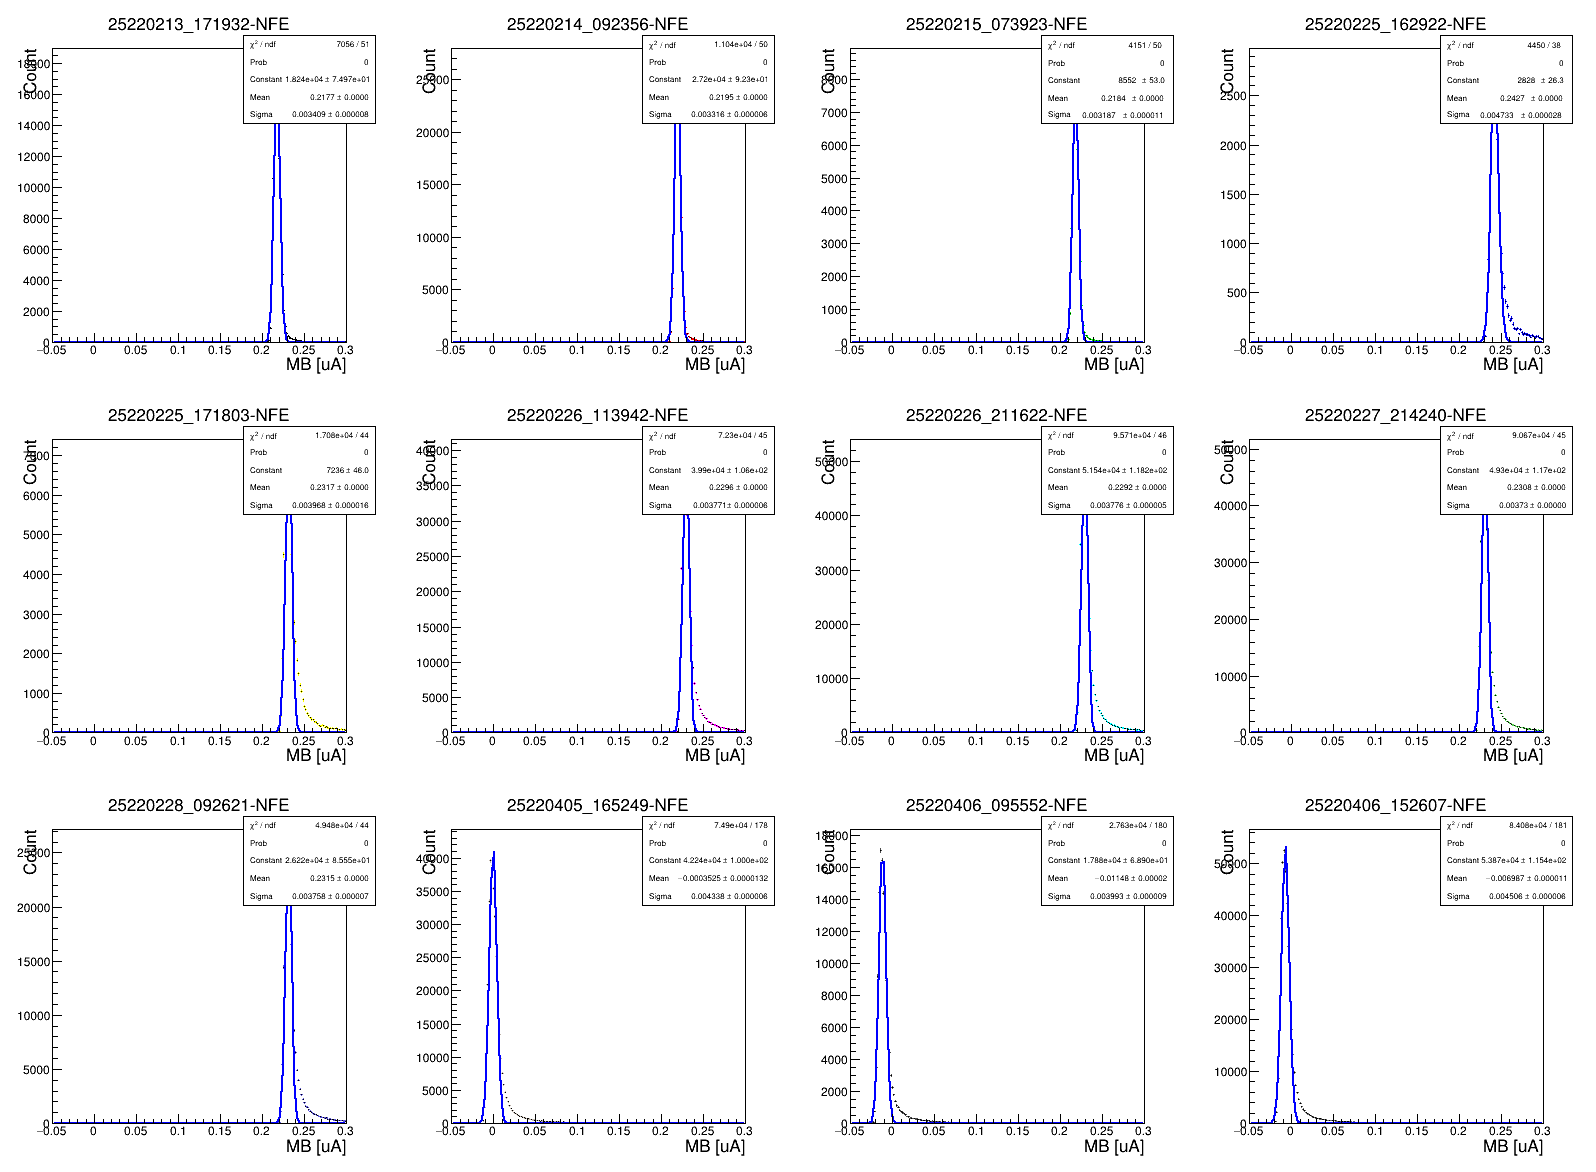

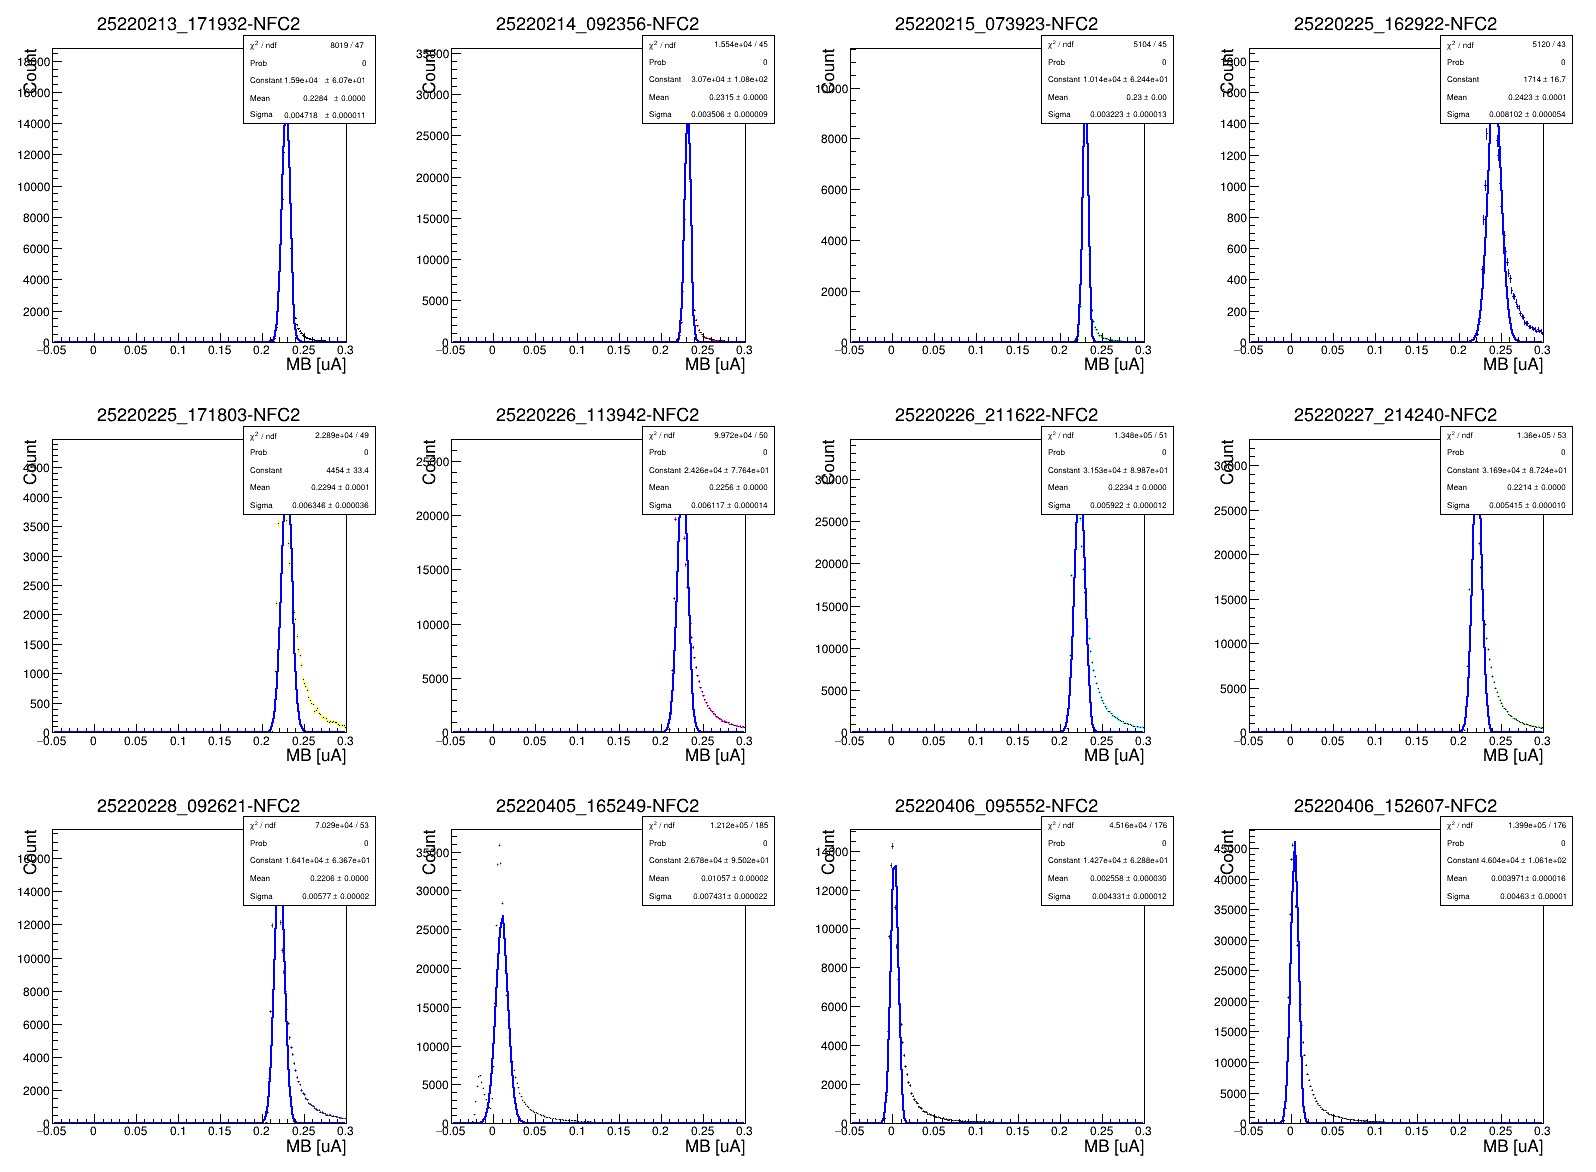

In [13]:
# Initial fit values.
canvas = {}
for det in tr:
    canvas[det] = ROOT.TCanvas(f"canvas_{det}","MB",1600,1200)
    canvas[det].cd()
    hist_stack[det].Draw('PADS')
    canvas[det].Draw()

In [14]:
# Book MB histograms again using parameter estimations from the first fit.
hists ={}
for count, series in enumerate(listHV_source):
    series = int(series)
    hists[count] = {}
    for det in tr:
        mean = MB_cut_values[count,det]['mean']
        sig = MB_cut_values[count,det]['sig']
        _min = mean - 6*sig
        _max = mean + 6*sig
        nbins = 100
        hists[count][det] = MB_series[det,count].Histo1D((f'MB_{count}_{det}',f'{series}-{det}'
                                                         ,nbins,_min,_max),
                                                         f'MeanBase_{det}_total')
        # axisx = hists[count][det].GetPtr().GetXaxis()
        # axisx.SetTitle(axisx_label)
        # axisx.SetTitleOffset(.8);
        # axisx.SetTitleSize(.05);
        # axisy = hists[count][det].GetPtr().GetYaxis()
        # axisy.SetTitle(axisy_label)
        # axisy.SetTitleOffset(.8);
        # axisy.SetTitleSize(.05);
        
print('Fine tuned hists ready')  

Fine tuned hists ready


In [ ]:
# Final MB cuts.
final_cuts = {}
for count, series in enumerate(listHV_source):
    for det in tr:
        mean = MB_cut_values[count,det]['mean']
        sig = MB_cut_values[count,det]['sig']
        _min = mean - 2*sig
        _max = mean + 1.5*sig
        fit[count,det] = ROOT.TF1(f"{count}_{det}","gaus(0)", _min,_max);
        fit[count,det].SetLineColor(2)
        fit[count,det].SetLineStyle(7)
        fit[count,det].SetLineWidth(2)
        fit[count,det].SetParameters(1.,mean,sig);
        sys.stdout.flush() 
        t.sleep(0.1) # Uproot needs #7.
        hists[count][det].Fit(f"{count}_{det}", 'LRMqS');
        
        mean = fit[count,det].GetParameter(1)
        sig = fit[count,det].GetParameter(2)
        final_cuts[count,det] = {'mean': mean,
                                 'sig': sig,
                                 'lower_3sig_cut': mean-3*sig,
                                 'upper_3sig_cut': mean+3*sig}

print('Fits ready')

Fits ready


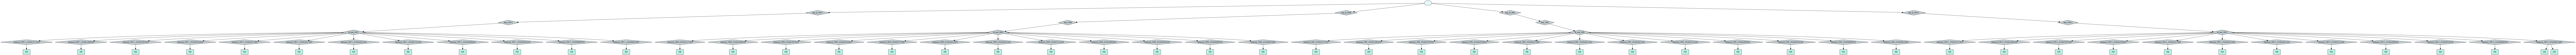

In [ ]:
# Computational graph ...
ROOT.RDF.SaveGraph(df, "./mydot1.dot");
!dot -Tpng mydot1.dot -ocomputation_graph1.png
Image("./computation_graph1.png")

Hist stacks ready


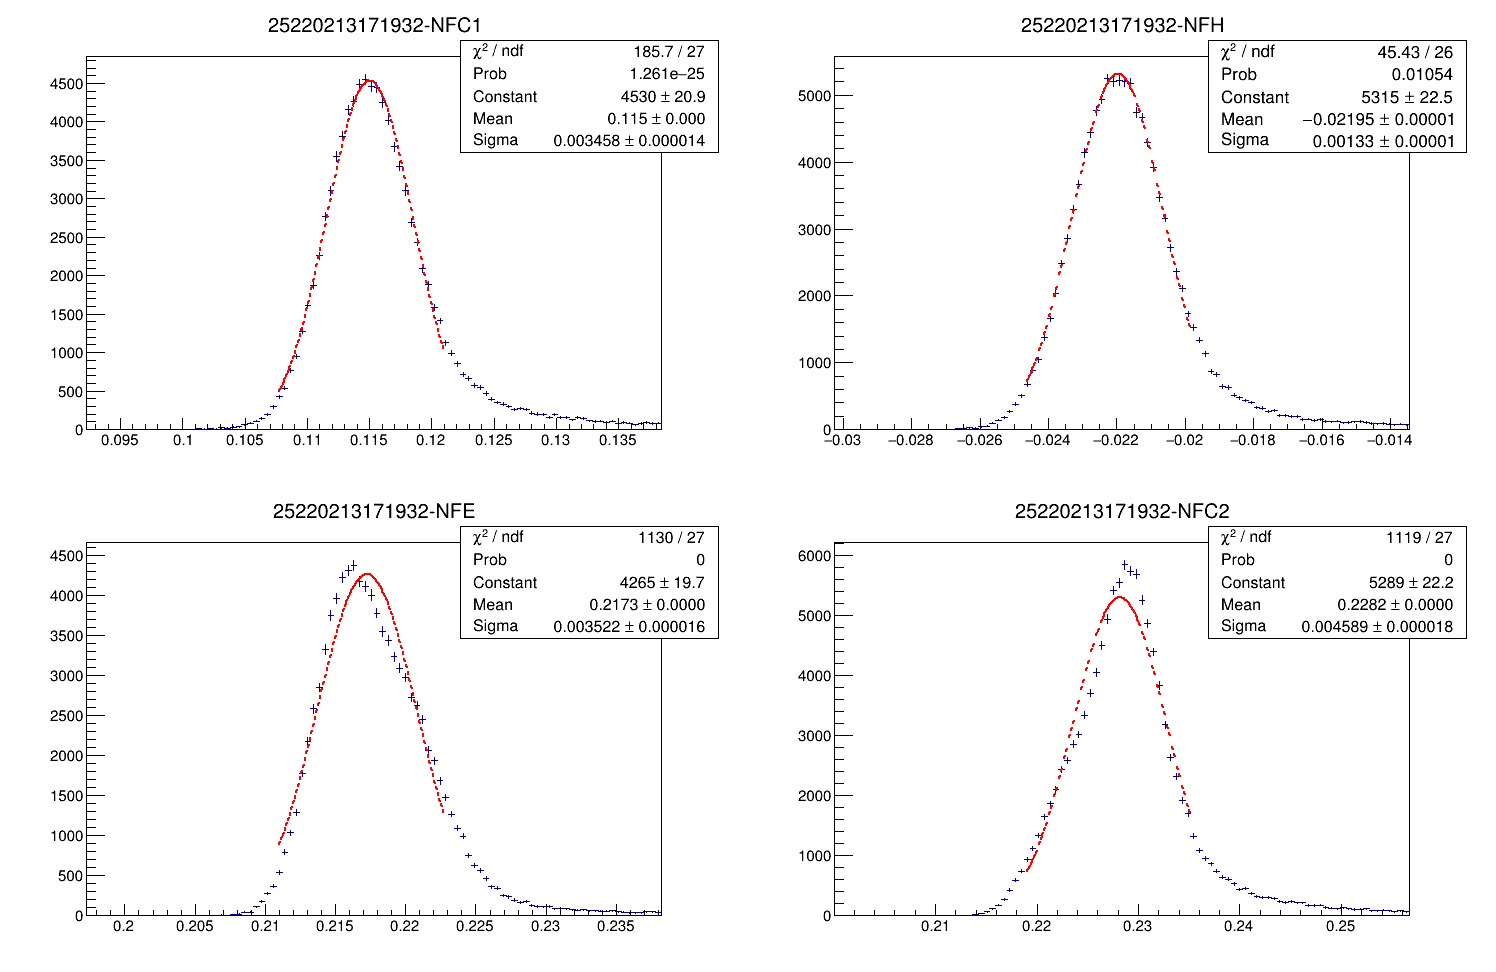

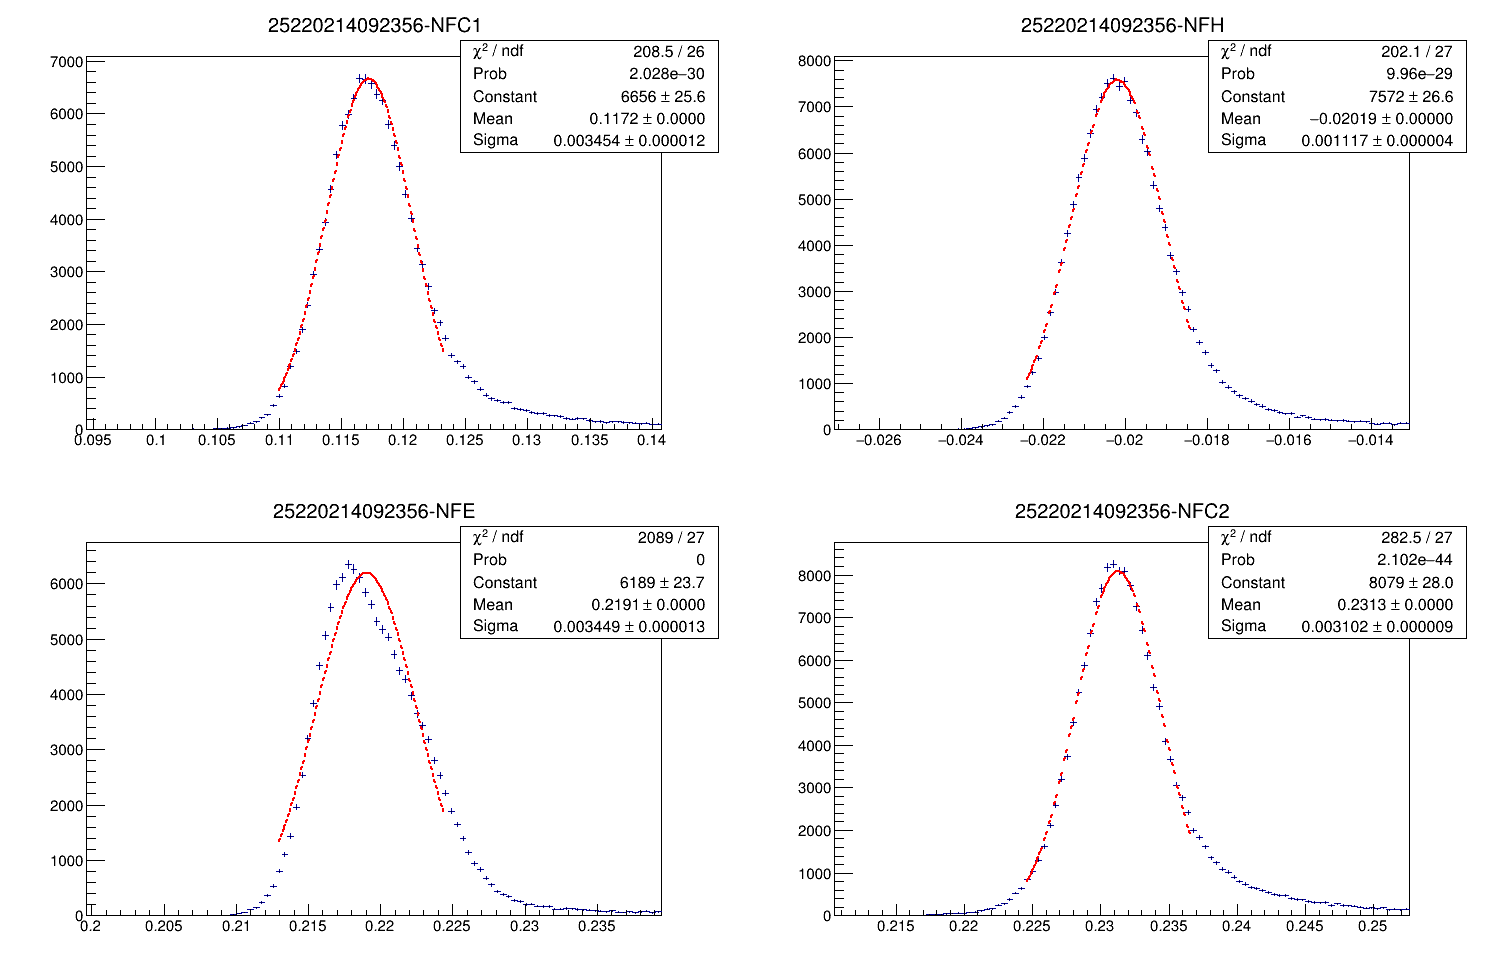

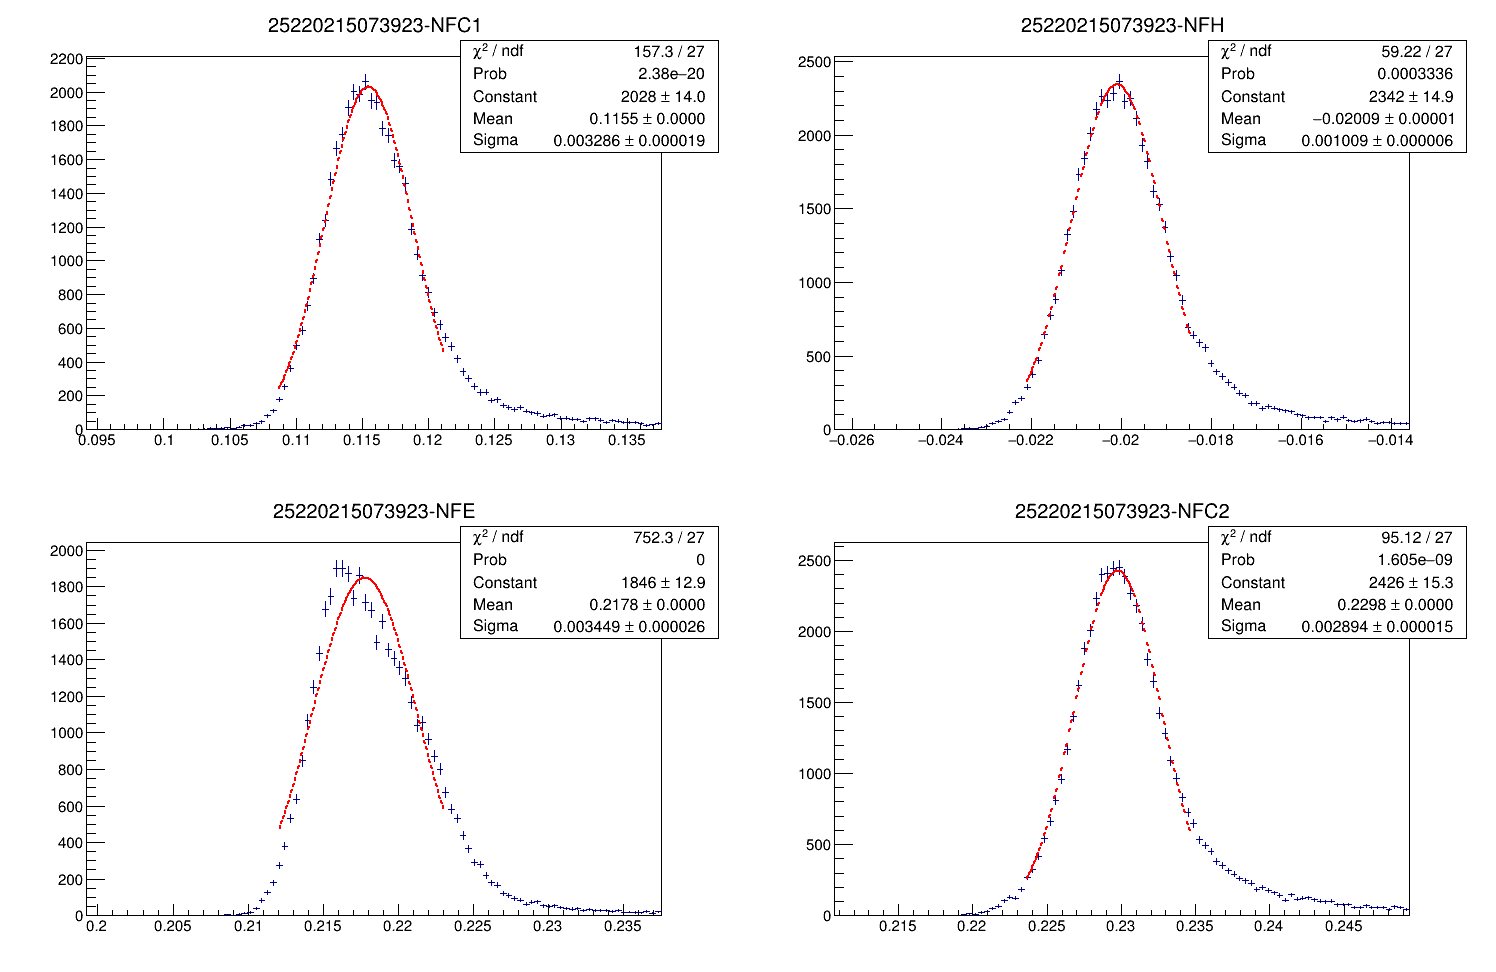

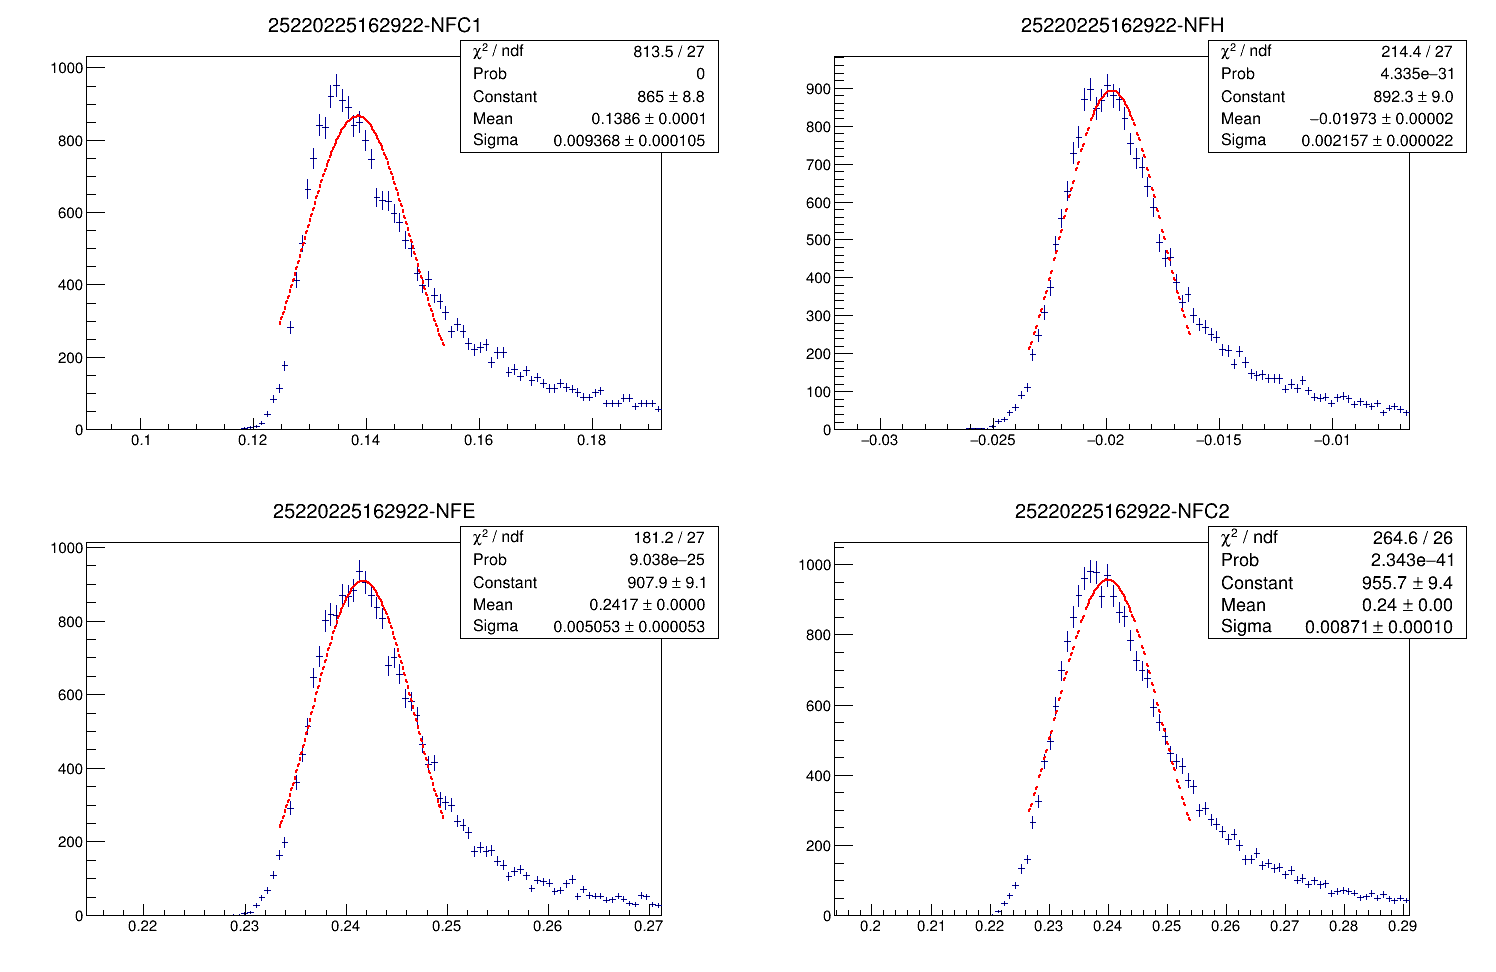

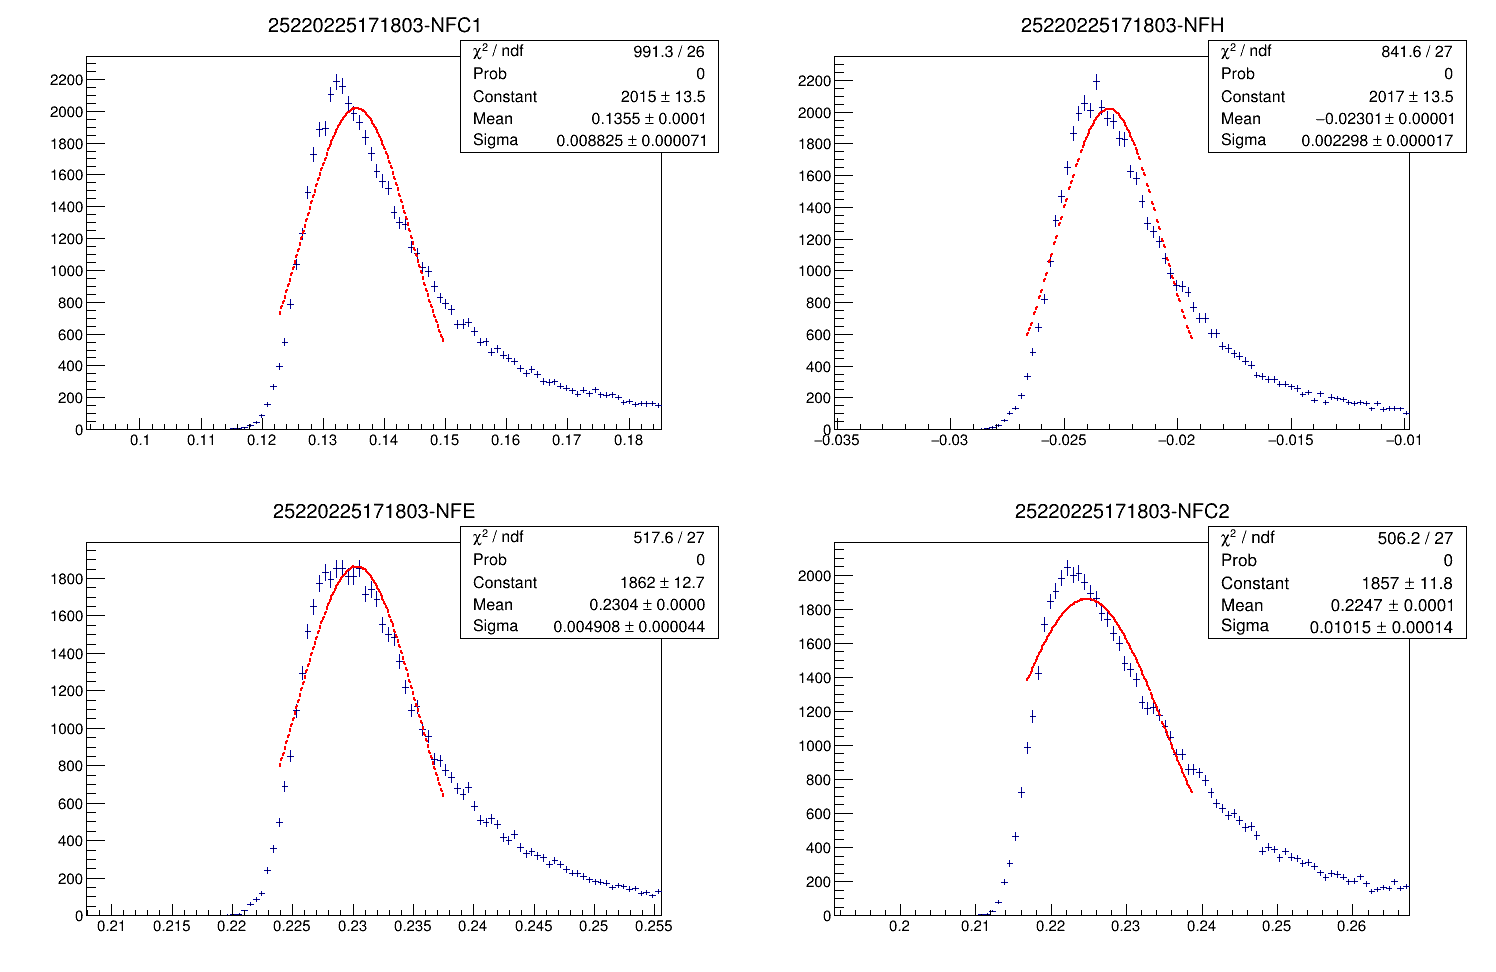

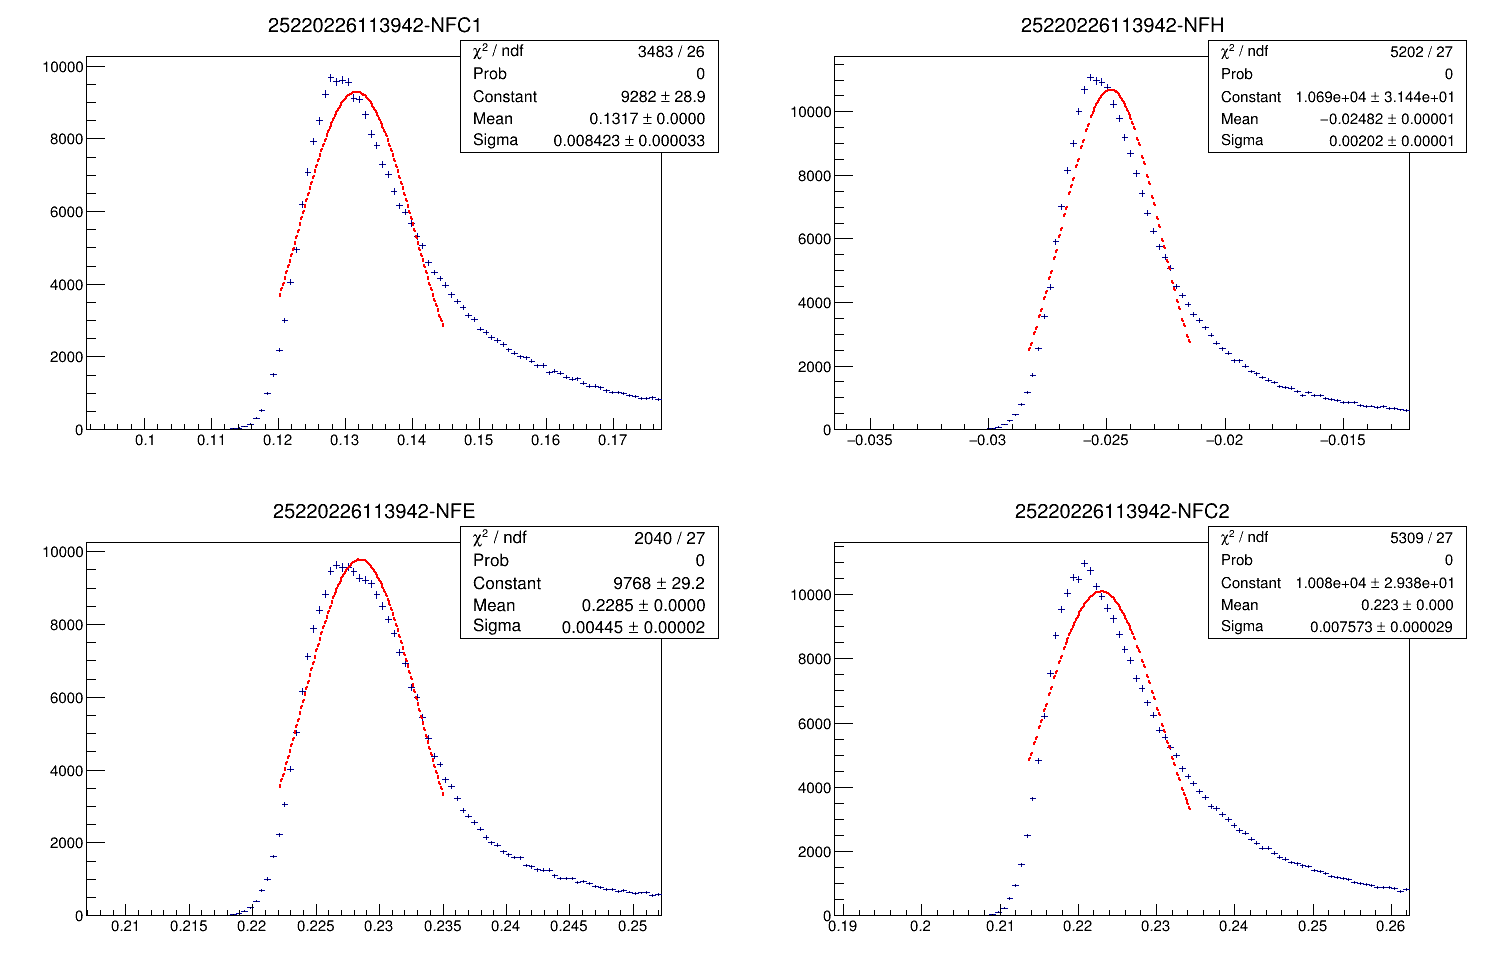

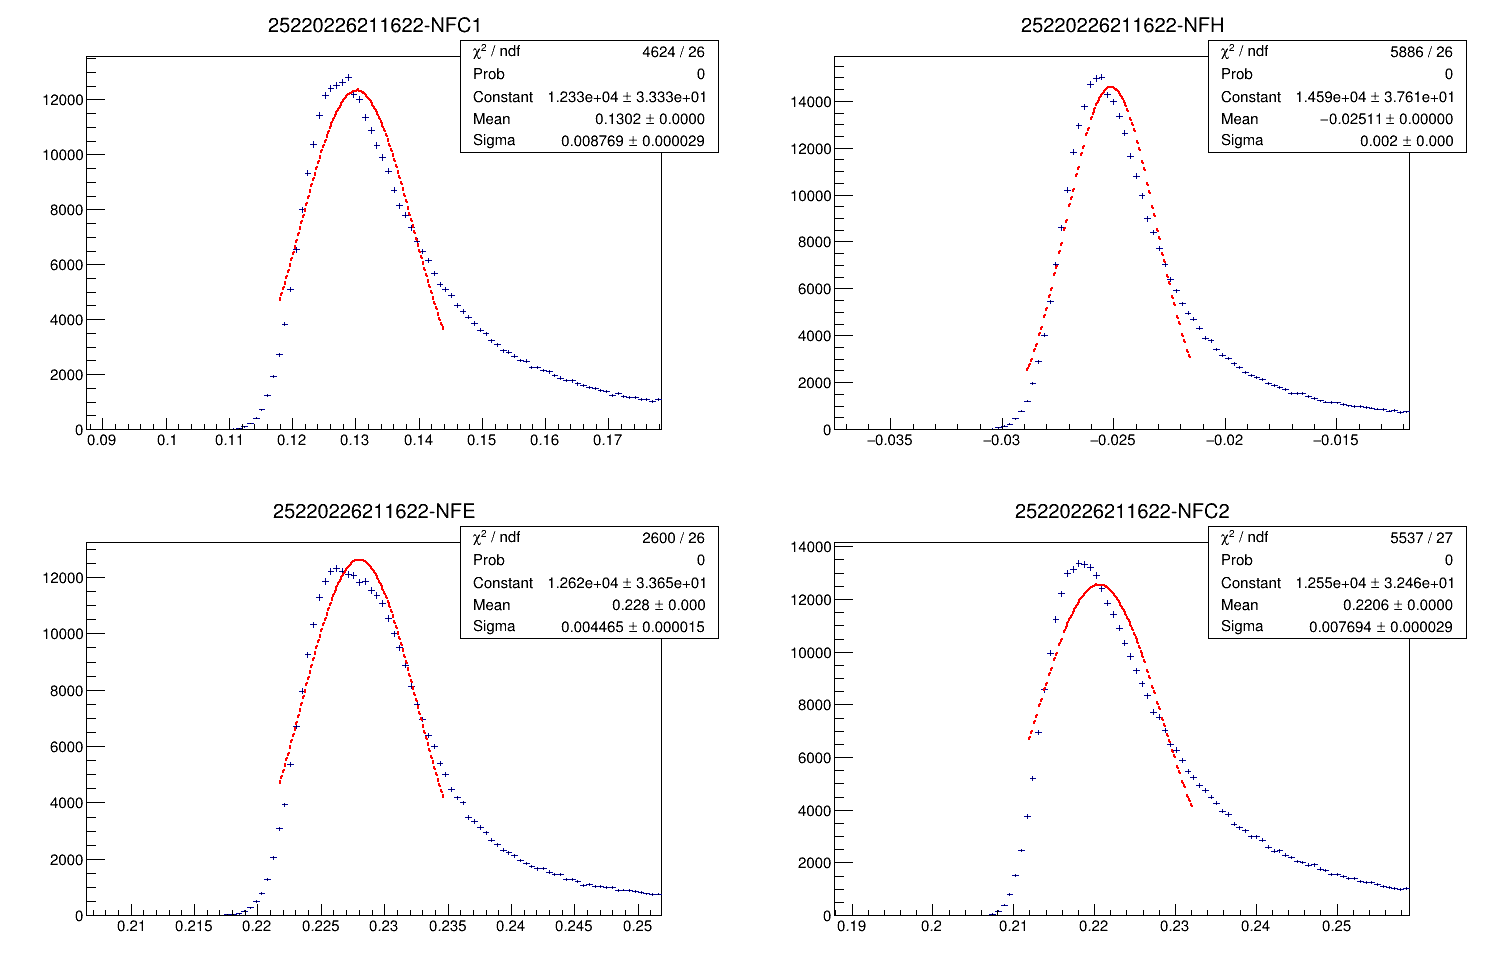

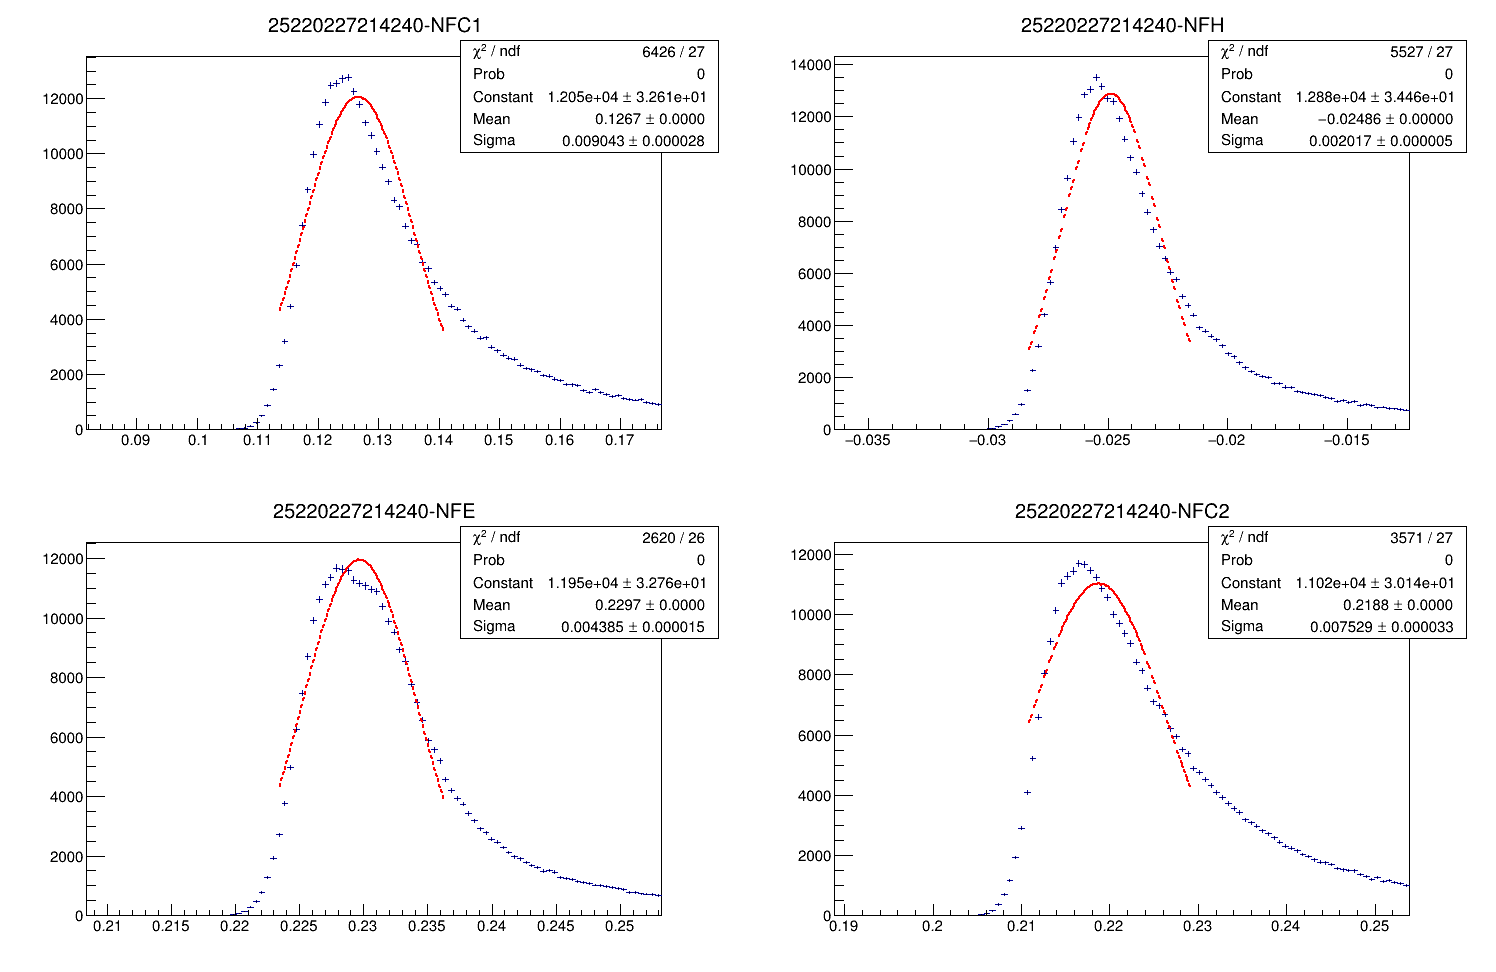

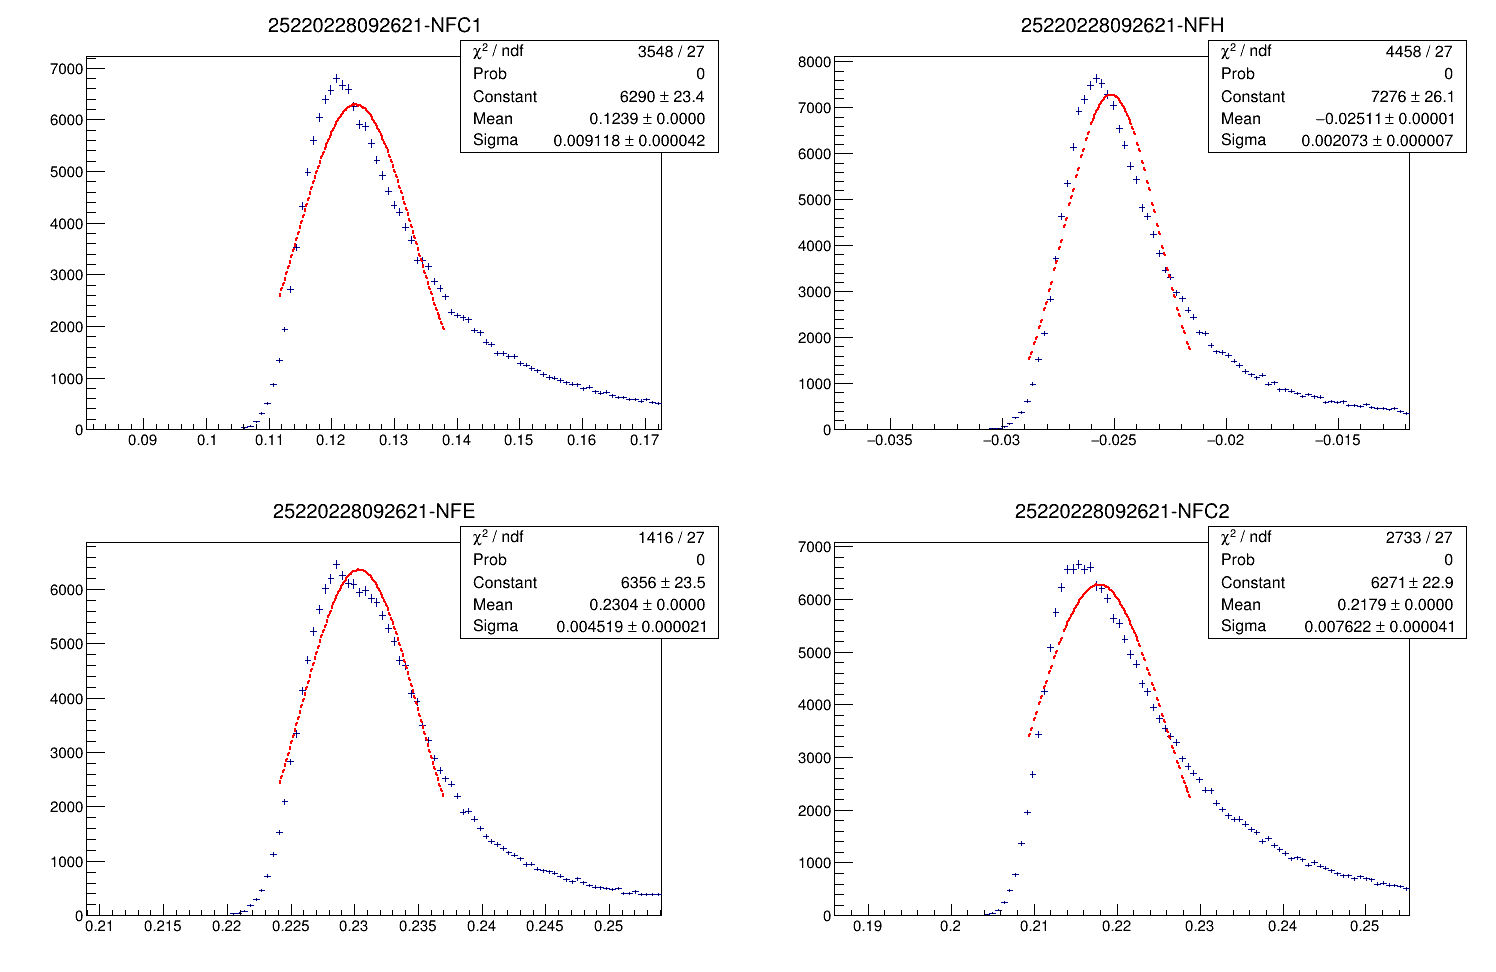

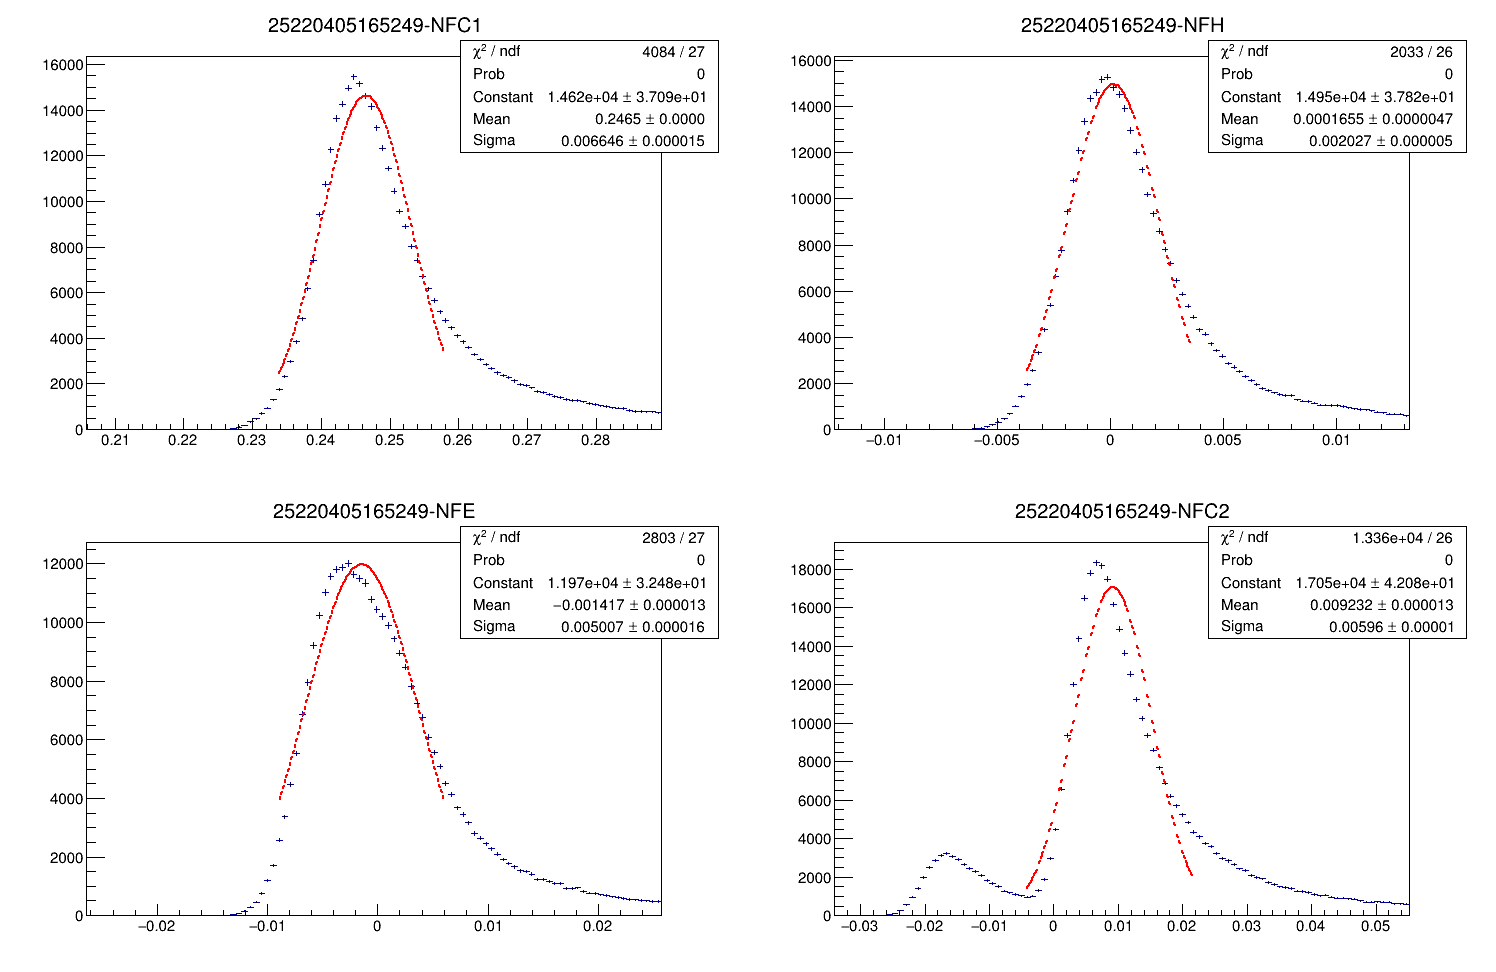

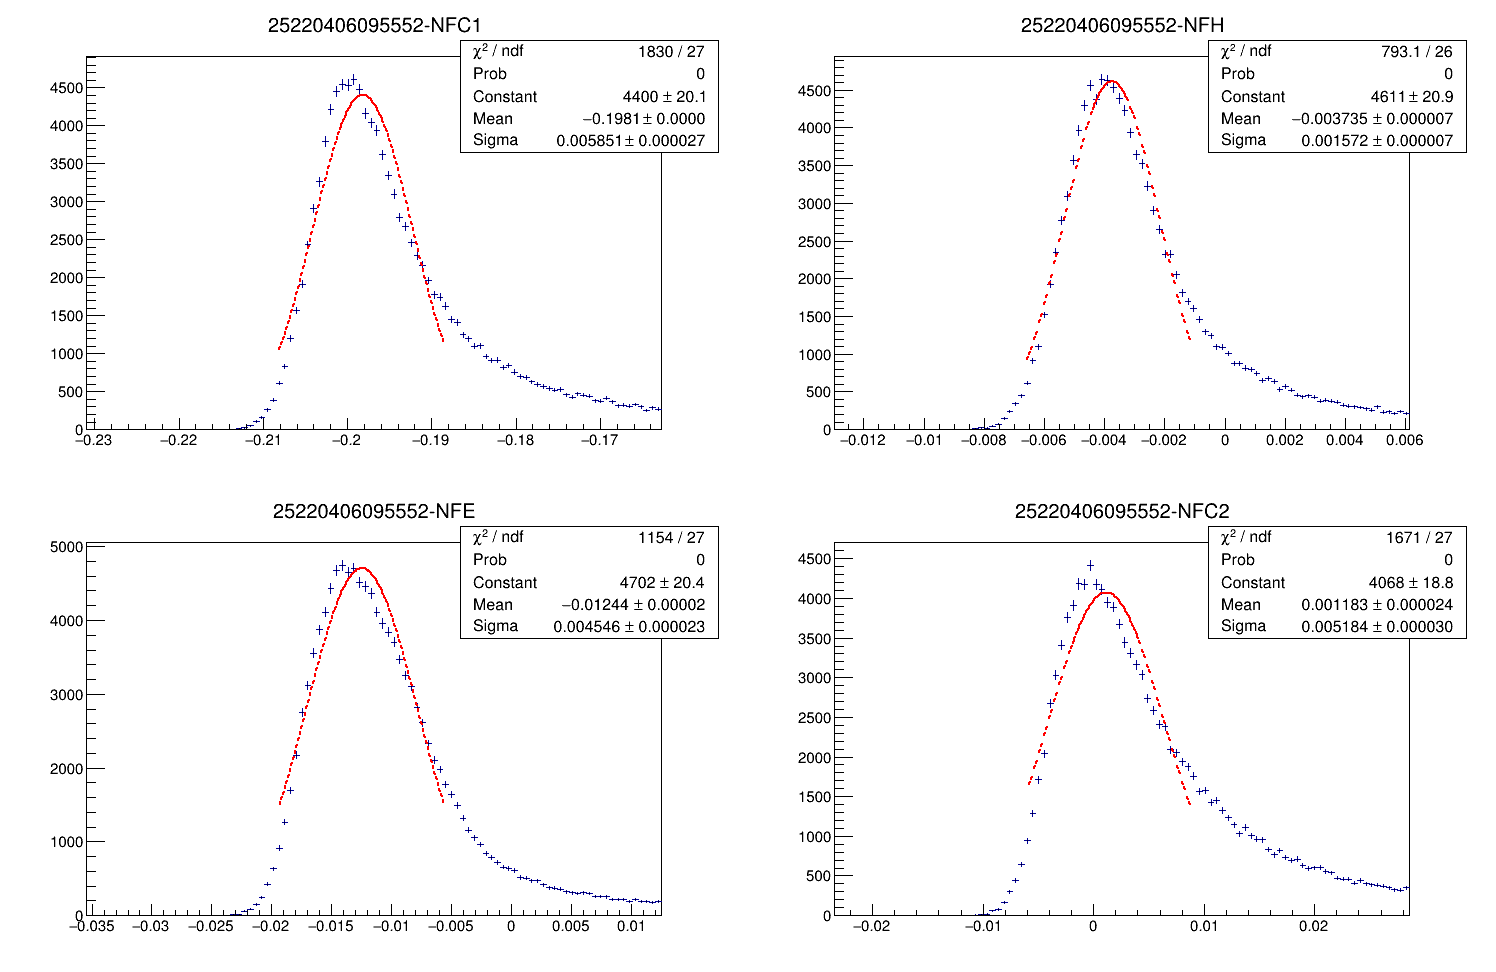

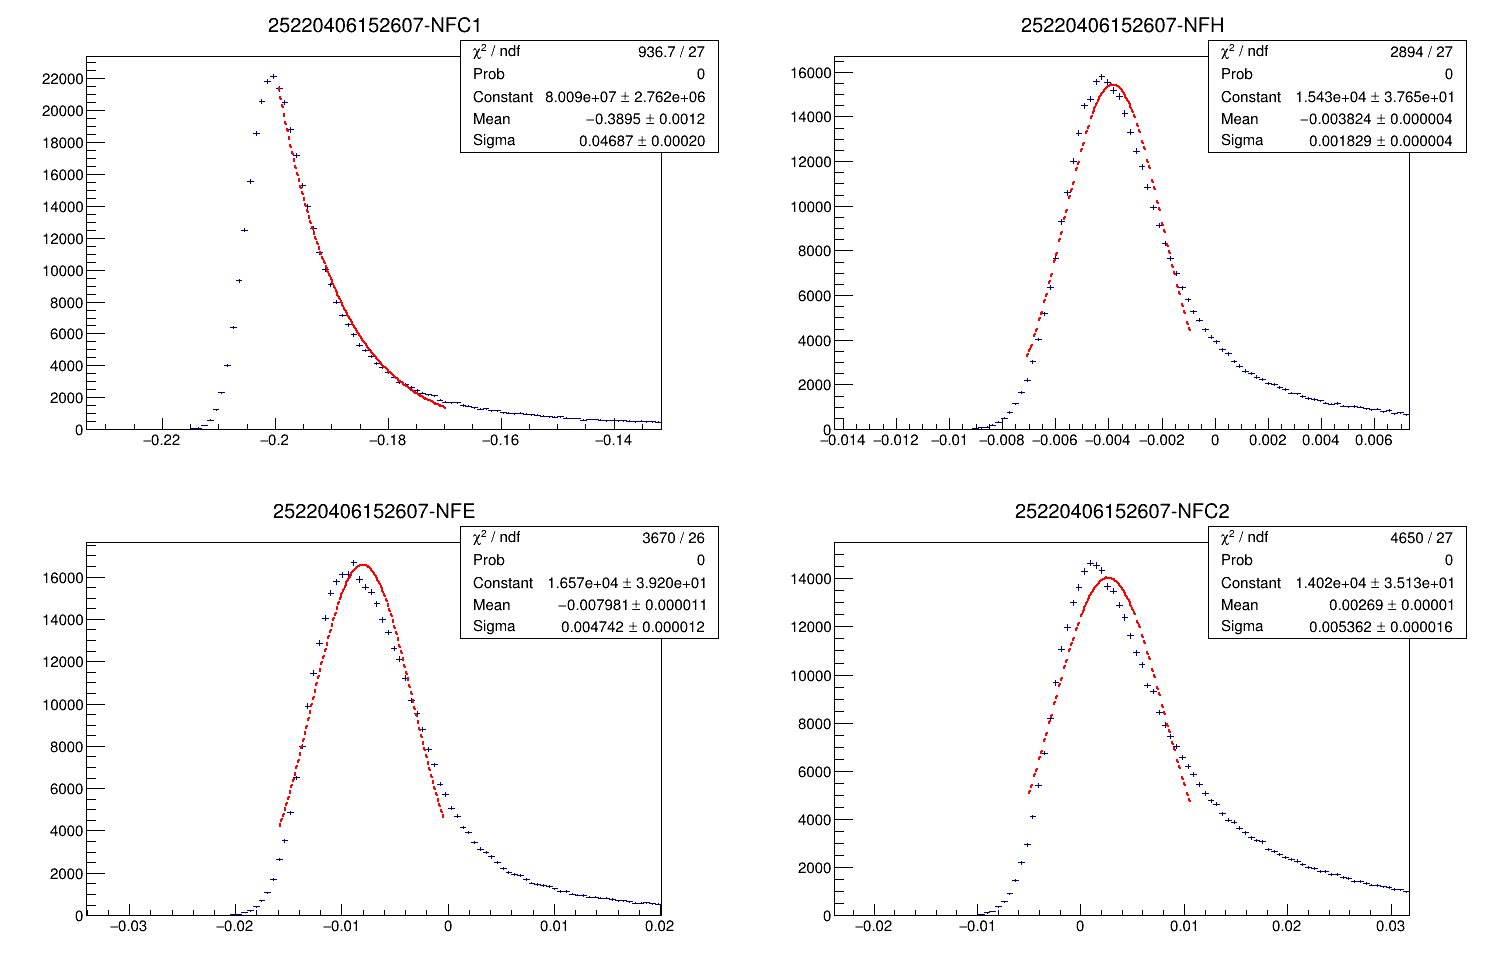

In [ ]:
# Series separated final cut results.
hist_stack = {}
for count in range(nrqs):
    hist_stack[count] = ROOT.THStack(f'{count}','')
    for det in tr:
        hist_stack[count].Add(hists[count][det].GetPtr())

print('Hist stacks ready')
canvas = {}
for count in range(nrqs):
    canvas[count] = ROOT.TCanvas(f"canvas_{count}","MB",1500,1000)
    canvas[count].cd()
    hist_stack[count].Draw('PADS')
    canvas[count].Draw()

In [ ]:
from numba.core import types
from numba.typed import Dict

In [71]:
# Use final fit parameters to define cuts.

func = {}
dict_ranges = {}
for det in tr:
    merged = ''
    dict_ranges[det] = {} #Dict.empty(
    #key_type=types.int64,
    #value_type=types.Tuple((types.float64, types.float64))
    #)
    for count, series in enumerate(listHV_source):
        upper = final_cuts[count,det]['upper_3sig_cut']
        lower = final_cuts[count,det]['lower_3sig_cut']
        switch = f'case {int(series)}: \n'
        cond = f'return {lower}<y && y<{upper};\n'
        merged = merged + switch + '\t' + cond + '\n'
        dict_ranges[det][int(series)] = (lower, upper)
    start = 'bool %s_%s_%i(unsigned long long x,long double y){\n switch(x) { \n'
    end = "} return 0; }"
    func[det] = start + merged + end

print('Cut sample:\n\n',func[det],'\n')

for det in tr:
    cuts['MB_cut',det] = func[det]

cuts.latest_call

Cut sample:

 bool %s_%s_%i(unsigned long long x,long double y){
 switch(x) { 
case 25220213171932: 
	return 0.21444079221170403<y && y<0.2419777363485578;

case 25220214092356: 
	return 0.22200058235359524<y && y<0.24061112917834018;

case 25220215073923: 
	return 0.22110400564351995<y && y<0.23847057491198842;

case 25220225162922: 
	return 0.21391346170466993<y && y<0.26617450306797175;

case 25220225171803: 
	return 0.1943026670215639<y && y<0.2551821297374066;

case 25220226113942: 
	return 0.20029054223545684<y && y<0.24573079910447143;

case 25220226211622: 
	return 0.19752922026829303<y && y<0.24369616521021645;

case 25220227214240: 
	return 0.19616490988356108<y && y<0.24133758775778644;

case 25220228092621: 
	return 0.19503527750177707<y && y<0.2407701650659051;

case 25220405165249: 
	return -0.00864695944934998<y && y<0.027110576266867376;

case 25220406095552: 
	return -0.014369766811704408<y && y<0.016735056209383422;

case 25220406152607: 
	return -0.01339515665361321<

{'global_time_series': 0,
 ('MB_cut', 'NFC1'): 3,
 ('MB_cut', 'NFH'): 3,
 ('MB_cut', 'NFE'): 3,
 ('MB_cut', 'NFC2'): 3}

In [67]:
dict_ranges["NFC1"]

{25220213171932: (0.10467359298183876, 0.1254212997050699),
 25220214092356: (0.10688321623520385, 0.12760760798523563),
 25220215073923: (0.10565103001200911, 0.125364350020151),
 25220225162922: (0.11048853484664412, 0.16669660809409276),
 25220225171803: (0.10907239040395392, 0.1620206153276985),
 25220226113942: (0.10645270312099324, 0.15699279200373378),
 25220226211622: (0.10391072518580938, 0.15652538307318678),
 25220227214240: (0.09956459464356117, 0.1538247118420802),
 25220228092621: (0.0965659367711403, 0.151271192529147),
 25220405165249: (0.22660603066727442, 0.26647995651642153),
 25220406095552: (-0.2156825162068894, -0.18057369095923523),
 25220406152607: (-0.5300659771965317, -0.24885844756780084)}

In [ ]:
from numba import njit

In [ ]:
dict_ranges = Dict.empty(
    key_type=types.int64,
    value_type=types.Tuple((types.float64, types.float64))
    )

In [ ]:
dict_ranges[3] = (1, 3)

In [ ]:
@njit
def cut(series, value, dict_ranges):
    return dict_ranges[series][0] < value < dict_ranges[series][1]

In [ ]:
def MB_cut_factory(dict_ranges):
    def inner(series, value):
        return cut(series, value, dict_ranges)
    return inner

In [ ]:
MB_cut_factory(dict_ranges)(3,2)

True

In [ ]:
a = MB_cut_factory(dict_ranges)

In [81]:
def MB_cut_factory(dict_ranges):
    exec("def cut(series, value):\n    dict_ranges=" +\
               dict_ranges.__str__() +\
            "\n    return dict_ranges[series][0] < value < dict_ranges[series][1]", globals())
    return cut

In [84]:
for det in tr:
    cut_name = f"MB_cut_{det}_n"
    cut = MB_cut_factory(dict_ranges[det])
    ROOT.Numba.Declare(['long', 'double'], 'bool', name=cut_name)(cut)

In [86]:
# At this point MB cuts for each series is ready. 
# Taking a step back (previous node layer) to have all series and apply cut funcs developed above.
mb_merged = {}
for det in tr:
    func_name = f"Numba::MB_cut_{det}_n"
    func_in1 =  'SeriesNumber'
    func_in2 =  f'MeanBase_{det}_total'
    call = f'{func_name}({func_in1},{func_in2})'
    mb_merged[det] = dt[det].Filter(f'{call}',f'MeanBase_{det}')

In [87]:
# I'm taking calibrations from Valentina's summary. 
# ~~~~~~~~~~~~~~~~~~I should add my previous work here!~~~~~~~~~~~~~~~~~~~~~~~~~~

# I think it's better to define chi2 cuts regardless of the calibration.
# Regardless of the calibration templates match the pulse shape less at higher OFL values.
# That has nothing to do with the calibration!
# 
calib={}  ## taken from Valentina's notebook
calib['NFE']= 0.103
calib['NFH']= 0.0488
calib['NFC1']= 0.129
calib['NFC2']= 0.0796

In [88]:
# chi2 cut intervals.
interval={}
for aa in range(0,14):
    interval[aa]=[0+aa*100, 100+aa*100]


hists_ready
(0, 100)
(100, 200)
(200, 300)
(300, 400)
(400, 500)
(500, 600)
(600, 700)
(700, 800)
(800, 900)
(900, 1000)
(1000, 1100)
(1100, 1200)
(1200, 1300)
(1300, 1400)


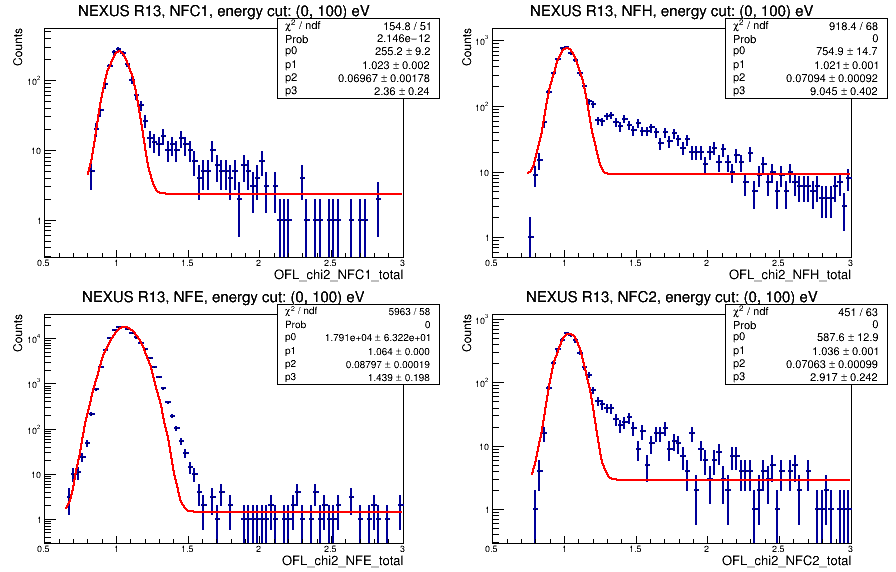

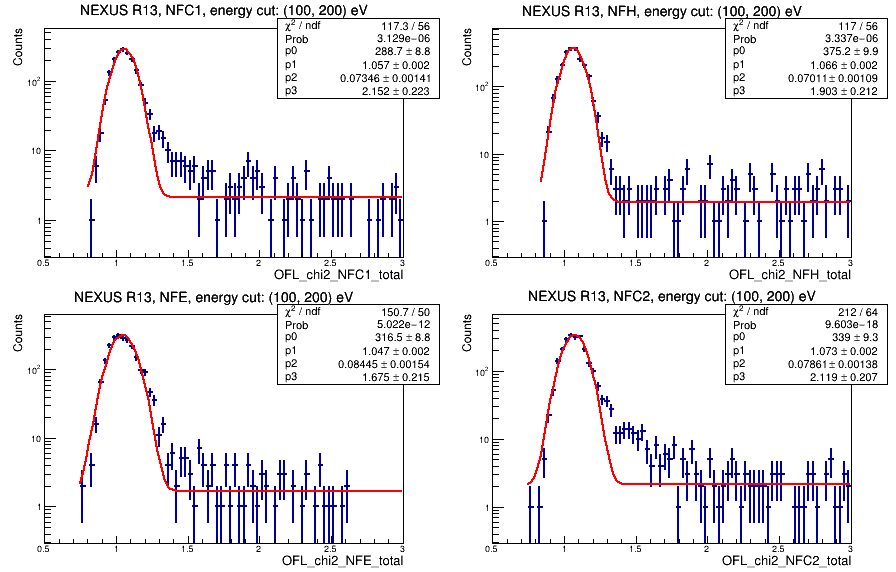

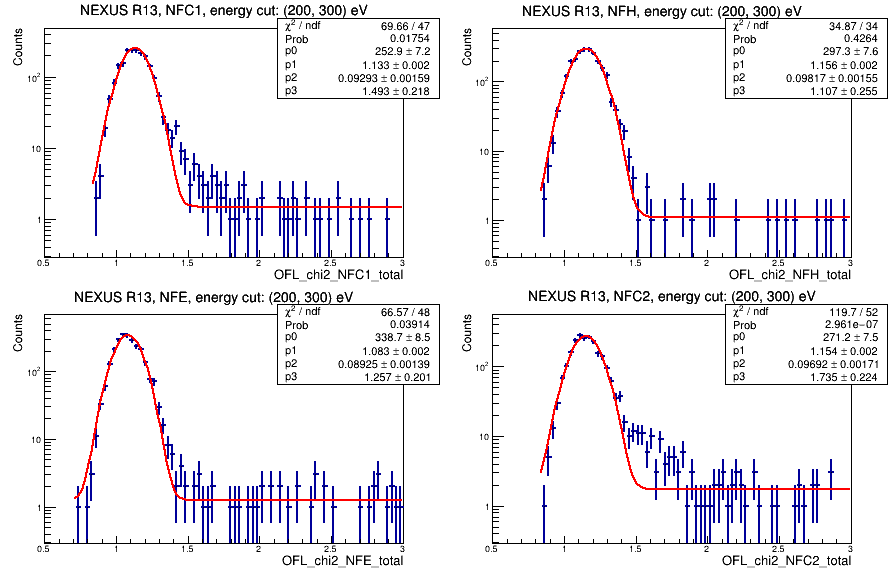

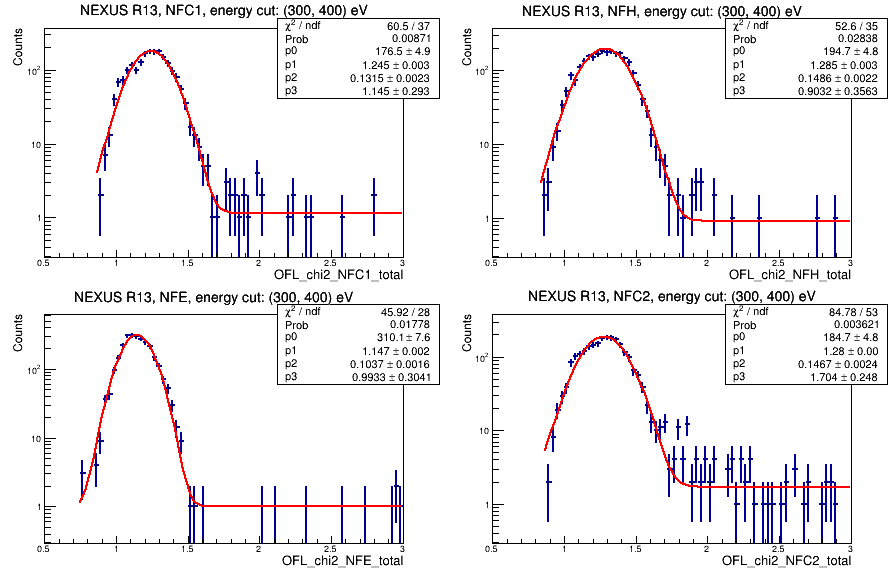

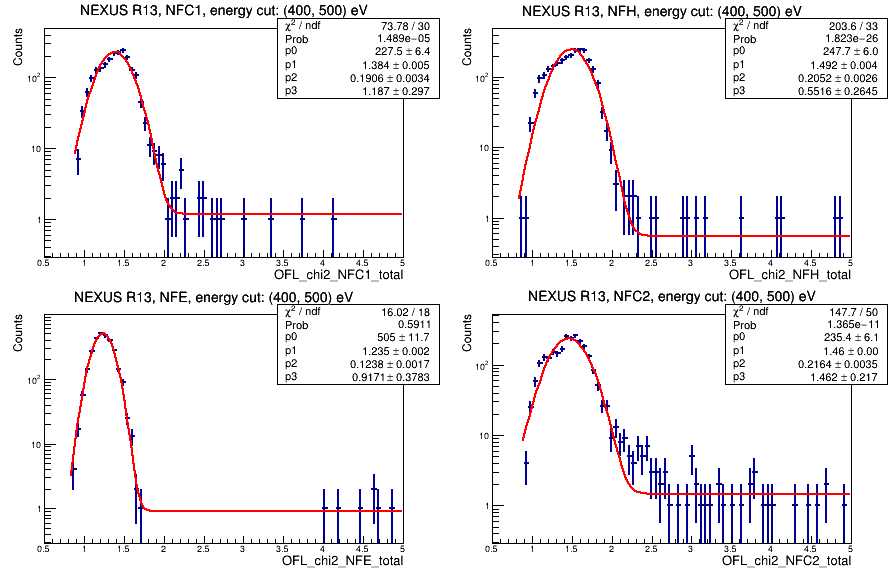

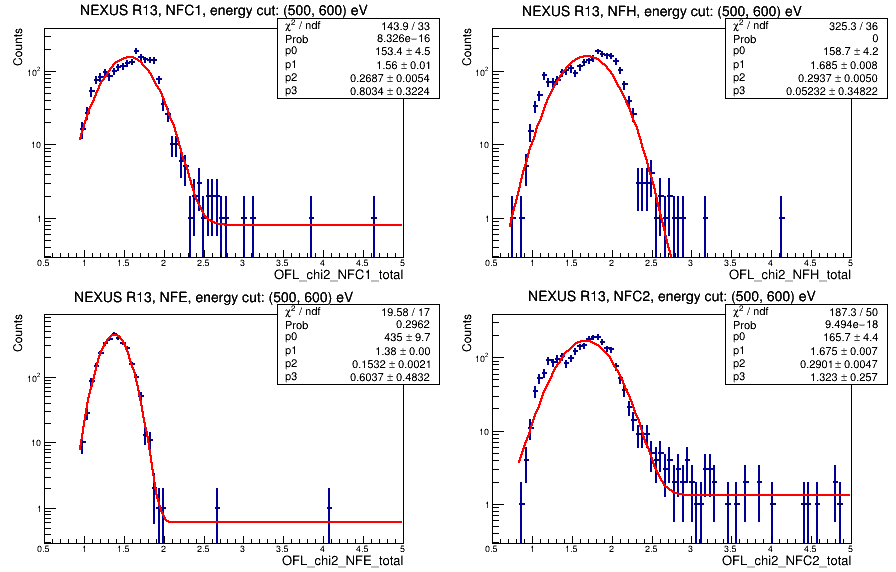

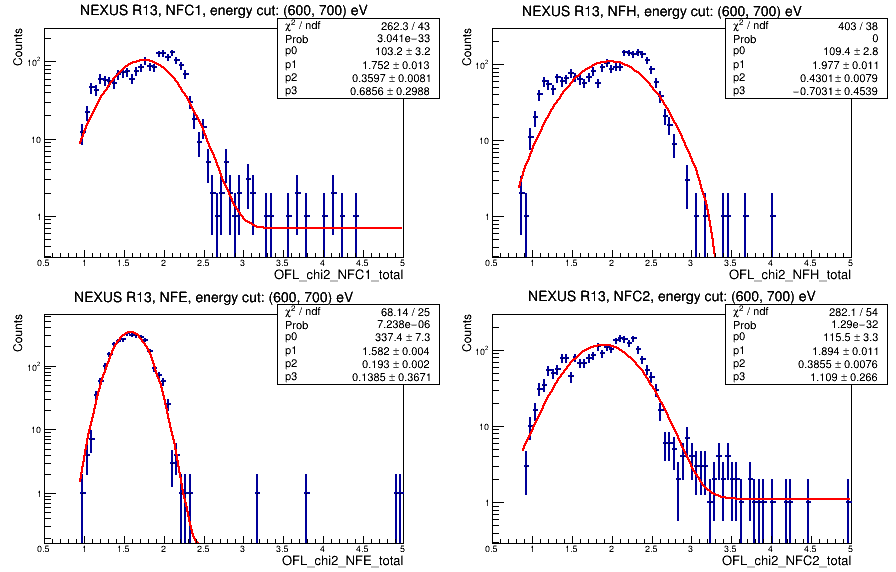

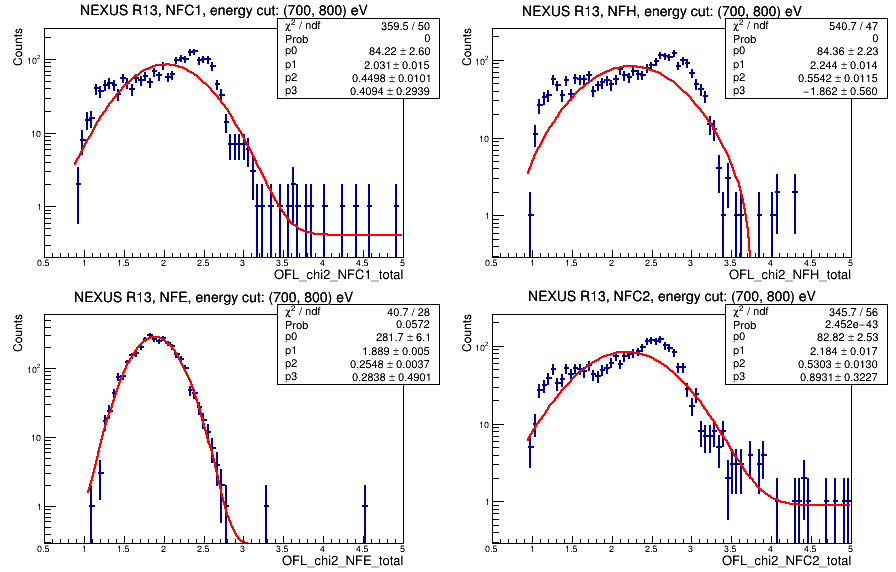

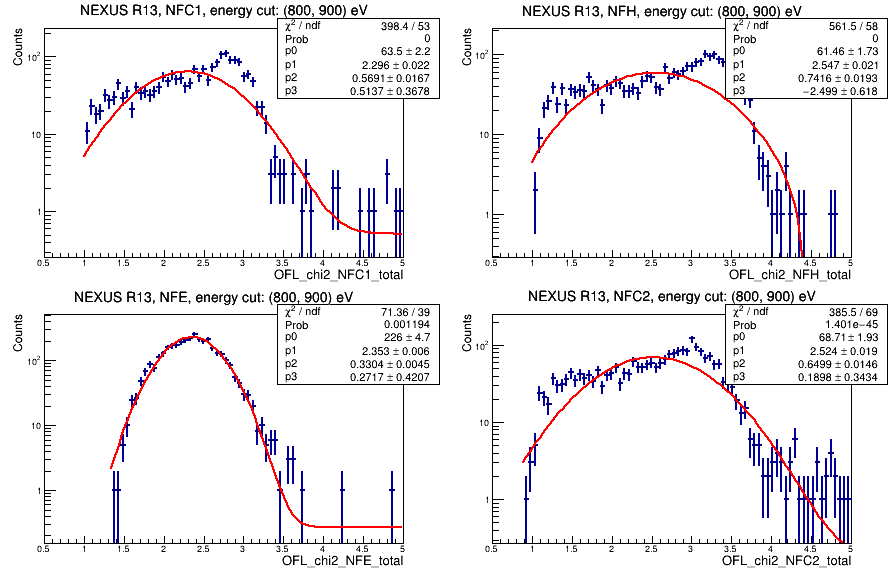

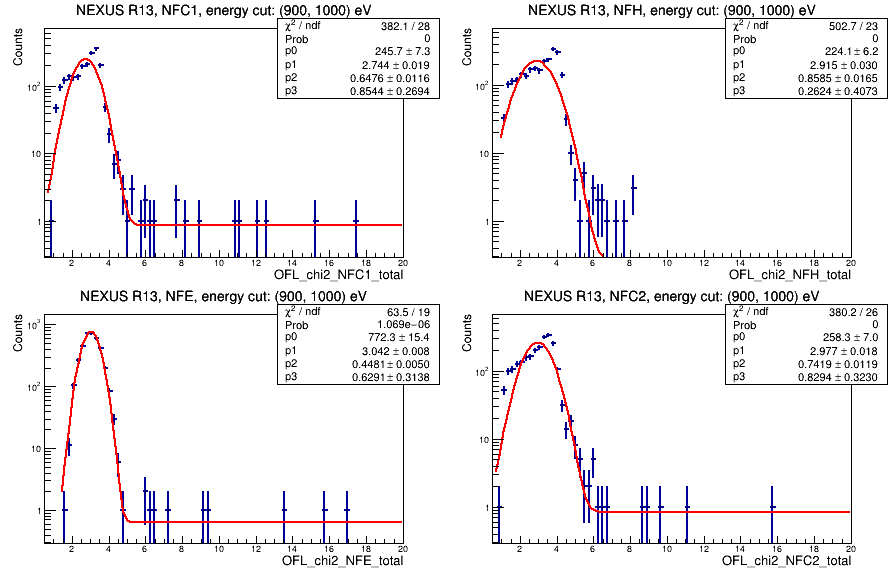

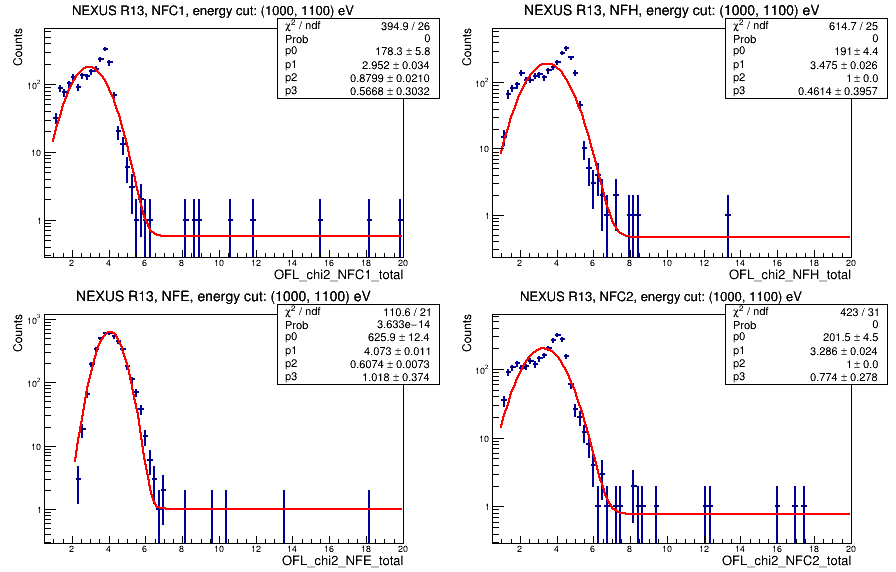

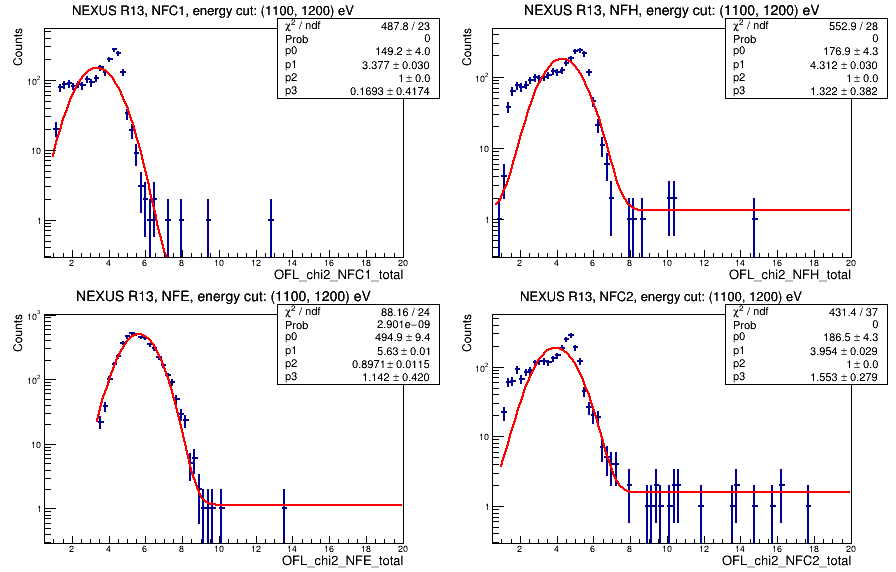

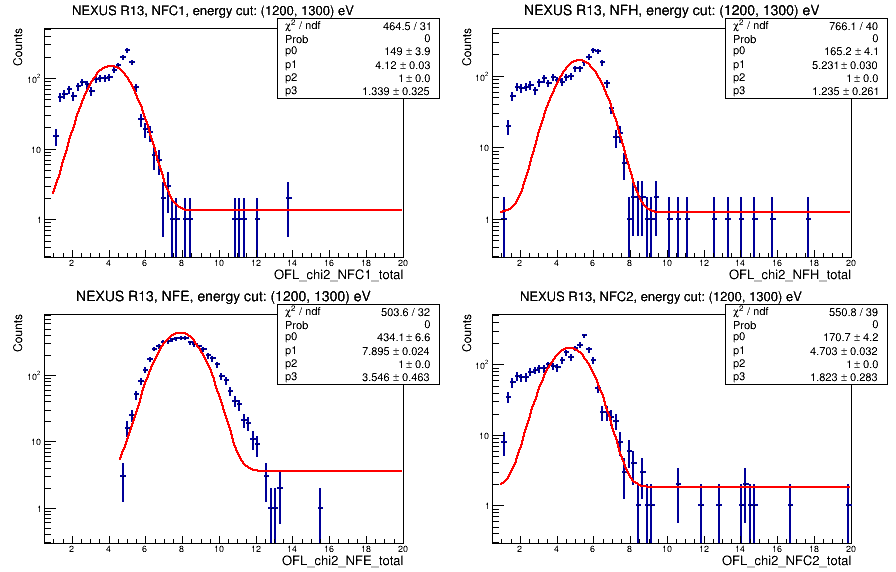

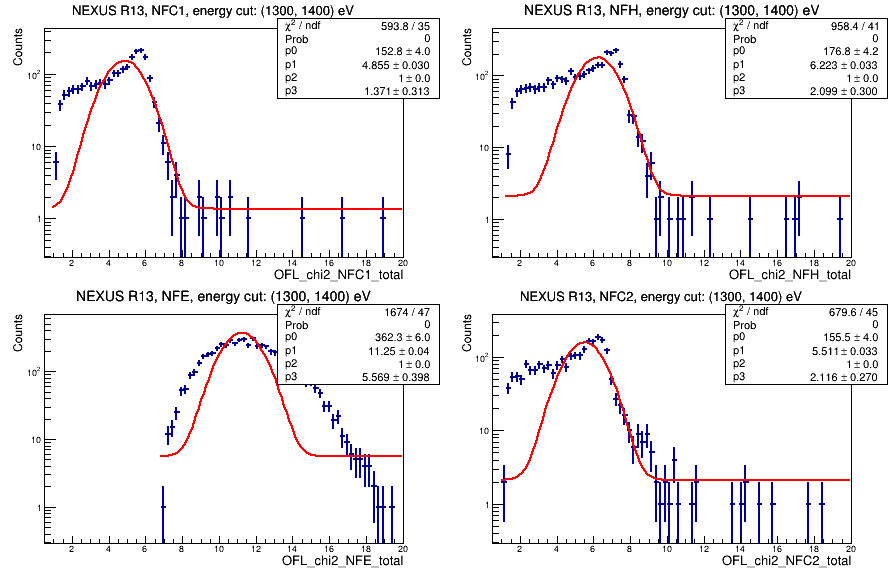

In [89]:
num_bin =80
h = {}
for _range in interval.values():
    if _range[1] < 500:
        _max = 3
        _min = 0.5

    elif _range[1] < 1000:
        _max = 5
        _min = 0.5

    elif _range[1] < 1500:
        _max = 20
        _min = 0.5

    elif _range[1] < 2000:
        _max = 20
        _min = 3
    elif _range[1] < 2500:
        _max = 25
        _min = 8

        
    _range = tuple(_range)
    h[_range]={}
    for det in tr.keys():
        
        h[_range][det] = ROOT.RDF.TH1DModel(f"h_{_range}_{det}", f'NEXUS R13, {det}, energy cut: {_range} eV', num_bin, _min, _max);
   
# MB_cut[det]
OFL_energy = {}
range_hists = {}
for det in tr:
    multiplier = 100/calib[det]
    OFL_energy[det] = mb_merged[det].Define(f'OFL_energy_{det}',f'OFL_{det}_total * {multiplier}')
    range_hists[det] = {}
    for _range in interval.values():
        _range = tuple(_range)
        edge_low = _range[0]
        edge_high = _range[1]
        range_hists[det][_range] = OFL_energy[det].Filter(f'{edge_low}<OFL_energy_{det} && OFL_energy_{det} <= {edge_high}')
        h[_range][det] = range_hists[det][_range].Histo1D(h[_range][det],f'OFL_chi2_{det}_total')

print('hists_ready')
c={}
f2={}
pad={}
chicut={}     

for _range in interval.values():
    
    num = tuple(_range)
    print(num)
    pad[num]={}
    f2[num]={}
    chicut[num]={}
    
    c[num] = ROOT.TCanvas("ce"+str(num),"",900,600)
    c[num].Draw()
    c[num].SetLogy()
    
    pad[num]['NFC1']=ROOT.TPad("p1","",0,0.5,0.5,1)
    pad[num]['NFH']=ROOT.TPad("p2","",0.5,0.5,1,1)
    pad[num]['NFE']=ROOT.TPad("p3","",0,0,0.5,0.5)
    pad[num]['NFC2']=ROOT.TPad("p4","",0.5,0,1,0.5)

    for ch in tr:
        pad[num][ch].Draw()
        pad[num][ch].SetLogy()
    
    for det in tr:
        h[num][ch] = h[num][ch].GetPtr()
        ch = det
        chicut[num][ch]={}
        pad[num][ch].cd()
        h[num][ch].Draw();
        axisx=h[num][ch].GetXaxis();
        axisx.SetTitle('OFL_chi2_'+ch+'_total');
        axisx.SetTitleSize(.05);
        axisx.SetTitleOffset(.8);


        axisy=h[num][ch].GetYaxis();
        axisy.SetTitle("Counts");
        axisy.SetTitleSize(.045);
        axisy.SetTitleOffset(.8);
        #axisy.SetRangeUser(1,100)        

        h[num][ch].SetLineWidth(2)

        binmax = h[num][ch].GetMaximumBin(); 
        xx = h[num][ch].GetXaxis().GetBinCenter(binmax);
        
        fit_start=0
        for jj in range(0,50):
            #print(fit_start)
            if (h[num][ch].GetBinContent(jj)>0):
                fit_start=h[num][ch].GetXaxis().GetBinCenter(jj-1)
                break

        if _range[1] < 500:
            _max = 3
            _min = 0.5

        elif _range[1] < 1000:
            _max = 5
            _min = 1

        elif _range[1] < 1500:
            _max = 20
            _min = 2

        elif _range[1] < 2000:
            _max = 20
            _min = 3

        elif _range[1] < 2500:
            _max = 25
            _min = 8
            
        f2[num][ch]=ROOT.TF1("f2"+str(num)+str(ch),"gaus(0)+[3]", fit_start,_max);
        f2[num][ch].SetParameters(10,xx,0.7,1);
        f2[num][ch].SetLineColor(2)
        f2[num][ch].SetParLimits(2,0,1);
        
        sys.stdout.flush() 
        t.sleep(0.1) # Uproot needs sleep to work.
        fit = h[num][ch].Fit('f2'+str(num)+str(ch), 'RqM'); 

        chicut[num][ch]['mean']=f2[num][ch].GetParameter(1)
        nsig_cut = 2
        chicut[num][ch]['cut']=f2[num][ch].GetParameter(1)+nsig_cut*f2[num][ch].GetParameter(2)
        if (f2[num][ch].GetParameter(2)<0): print(num, ch, f2[num][ch].GetParameter(2)<0)
        chicut[num][ch]['cuterr']=math.sqrt(f2[num][ch].GetParError(1)**2+nsig_cut**2*(f2[num][ch].GetParError(2)**2))   

 FCN=134.745 FROM HESSE     STATUS=OK             16 CALLS         191 TOTAL
                     EDM=180.498    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.63156e-06   2.85271e-07   7.54547e-11   7.69772e+04
   2  p1           1.94579e+00   8.78721e-03   2.37594e-06  -2.15985e+03
   3  p2           1.12072e+00   3.00825e-03   1.09359e-05   5.11952e-01
 FCN=495.15 FROM HESSE     STATUS=OK             16 CALLS         173 TOTAL
                     EDM=707.715    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.95455e-06   2.45595e-07   1.44183e-10  -2.83158e+02
   2  p1           1.93845e+00   5.93935e-03   3.54146e-06  -6.33440e+03
   3  p2           1.11983e+00   1.97288e-

Info in <CheckGraphFitOptions>: L (Log Likelihood fit) is an invalid option when fitting a graph. It is ignored
Info in <CheckGraphFitOptions>: L (Log Likelihood fit) is an invalid option when fitting a graph. It is ignored
Info in <CheckGraphFitOptions>: L (Log Likelihood fit) is an invalid option when fitting a graph. It is ignored
Info in <CheckGraphFitOptions>: L (Log Likelihood fit) is an invalid option when fitting a graph. It is ignored


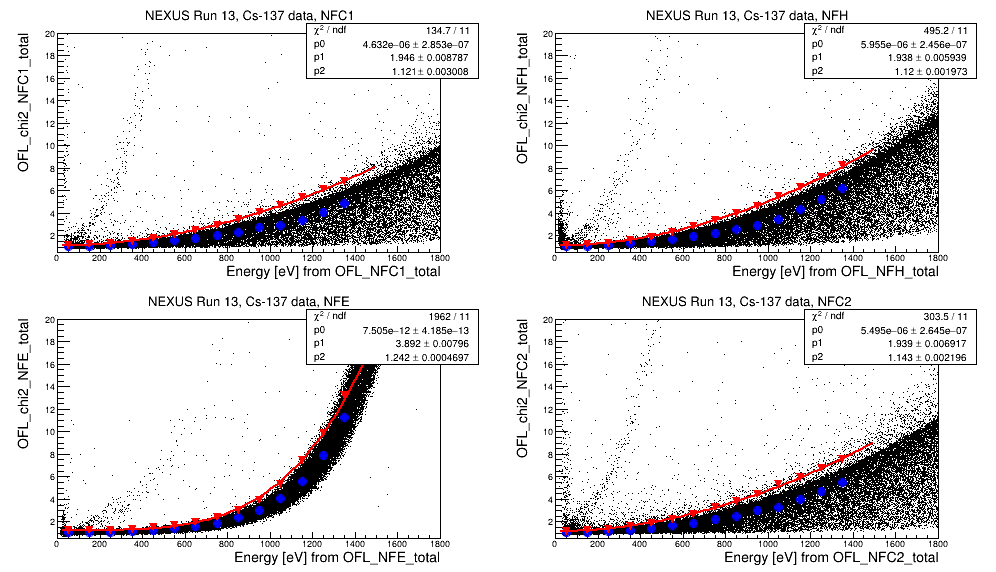

In [90]:
canvas = {}
graph = {}
last_series = 0
count = {}
gr = {}
for det in tr:
    gr[det] = ROOT.TGraph()
    gr[det].SetTitle(f'{det}')
    gr[det].SetName(f'{det}')
    count[f'{det}'] = 0
energy_chi_cond = {}
for det in tr:
    energy_chi_cond[det] = OFL_energy[det].Filter(f'0<OFL_energy_{det} && OFL_energy_{det}<2500', f'OFL energy {det}')
    gr[det] = energy_chi_cond[det].Graph(f'OFL_energy_{det}', f'OFL_chi2_{det}_total')


gr2 = {}
gr3 = {}
f={}
chipar ={}
c={}

c = ROOT.TCanvas("c","",1000,600)
c.Divide(2,2)

ROOT.gStyle.SetOptFit(1);
for i, ch in enumerate (tr):  
    chipar[ch]={}
    gr2[ch] = ROOT.TGraph();
    gr3[ch] = ROOT.TGraphErrors();
    c.cd(i+1)
     
    for num in interval:
        _range = tuple(interval[num])
        gr2[ch].SetPoint(num, (interval[num][1]+interval[num][0])/2,chicut[_range][ch]['mean'])   
        gr3[ch].SetPoint(num, (interval[num][1]+interval[num][0])/2,chicut[_range][ch]['cut'])
        gr3[ch].SetPointError(num,0,chicut[_range][ch]['cuterr']);

    gr[ch].SetTitle('NEXUS Run 13, Cs-137 data, '+ ch)
    gr[ch].SetMarkerStyle(1)
    gr2[ch].SetMarkerStyle(8)
    gr2[ch].SetMarkerColor(4)
    gr2[ch].SetLineColor(1)
    gr3[ch].SetMarkerStyle(23)
    gr3[ch].SetMarkerColor(2)
    gr3[ch].SetLineColor(2)

    axisx=gr[ch].GetXaxis();
    axisx.SetTitle('Energy [eV] from OFL_'+ch+'_total');
    axisx.SetTitleSize(.055);
    axisx.SetTitleOffset(.8);
    axisx.SetLimits(0,1800)

    axisy=gr[ch].GetYaxis();
    axisy.SetTitle('OFL_chi2_'+ch+'_total');
    axisy.SetTitleSize(.055);
    axisy.SetTitleOffset(.8);
    axisy.SetRangeUser(0.5,20)

    gr[ch].Draw('AP')
    gr2[ch].Draw('p,same')
    gr3[ch].Draw('p,same')

    f[ch]=ROOT.TF1("f"+ch,"[0]*(x)**[1]+[2]",15,1500);
    f[ch].SetParameters(0.01,2,1);
    #f.SetParameters(1,1,0);
    fit = gr3[ch].Fit('f'+ch, 'LRM');

    chipar[ch]['a']=f[ch].GetParameter(0)
    chipar[ch]['b']=f[ch].GetParameter(1)
    chipar[ch]['c']=f[ch].GetParameter(2) 
c.Draw()

In [91]:
# We define the chi2 cuts using the data from above.
_str = {}
for det in tr:
    a = chipar[det]['a']
    b = chipar[det]['b']
    c = chipar[det]['c']
    _str[det] ='''
bool %s_%s_%s(long double x,double y){ 
    float func =  %s*pow((x),%s)+%s;
    bool cond1 = x<1000 && y < func;
    bool cond2 = x>1000;
    return cond1 || cond2;
}
'''%('%s','%s','%s',a,b,c)
_str
for det in tr:
    cuts['chi2_cut',det] = _str[det]
cuts.latest_call

{'global_time_series': 0,
 ('MB_cut', 'NFC1'): 3,
 ('MB_cut', 'NFH'): 3,
 ('MB_cut', 'NFE'): 3,
 ('MB_cut', 'NFC2'): 3,
 ('chi2_cut', 'NFC1'): 3,
 ('chi2_cut', 'NFH'): 3,
 ('chi2_cut', 'NFE'): 3,
 ('chi2_cut', 'NFC2'): 3}

In [92]:
nbins = 50
xmin = 0    
xmax = 2500
nhist = 2
hists = tools.hist_builder(nbins,xmin,xmax,tr,nhist)
# Look at the energy range of interst
interesting_energy ={}
for det in tr:
    interesting_energy[det] = OFL_energy[det].Filter(f'OFL_energy_{det}>{xmin} && OFL_energy_{det}<{xmax}',f'{xmin}_{xmax}_{det}')

# Apply chi2 cut.
chi2_cut = {}
for det in tr:
    func_name = cuts['chi2_cut',det]
    func_in1 =  f'OFL_energy_{det}'
    func_in2 =  f'OFL_chi2_{det}_total'
    call = f'{func_name}({func_in1},{func_in2})'
    chi2_cut[det] = interesting_energy[det].Filter(f'{call}',f'chi2_cut_{det}')
#     print(chi2_cut)
#     hists[0][det] = interesting_energy[det].Histo1D(hists[0][det],f'OFL_{det}_total')
#     hists[1][det] = chi2_cut[det].Histo1D(hists[1][det],f'OFL_{det}_total')

    hists[0][det] = interesting_energy[det].Histo1D(hists[0][det],f'OFL_energy_{det}')
    hists[1][det] = chi2_cut[det].Histo1D(hists[1][det],f'OFL_energy_{det}')

In [93]:
#Check passage fractions
# cut_report = {}
# for det in tr:
#     cut_report[det] = chi2_cut[det].Report()
#     cut_report[det].Print()  

(<cppyy.gbl.TCanvas object at 0x55faa7d7a0b0>,
 {'NFC1': <cppyy.gbl.TLegend object at 0x55faa7c98a60>,
  'NFH': <cppyy.gbl.TLegend object at 0x55faa8e1f7f0>,
  'NFE': <cppyy.gbl.TLegend object at 0x55faa901cc60>,
  'NFC2': <cppyy.gbl.TLegend object at 0x55faab238220>},
 {'NFC1': <cppyy.gbl.THStack object at 0x55faa3f9f4f0>,
  'NFH': <cppyy.gbl.THStack object at 0x55faa73c59b0>,
  'NFE': <cppyy.gbl.THStack object at 0x55faa55e48e0>,
  'NFC2': <cppyy.gbl.THStack object at 0x55faa7c6dba0>})

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


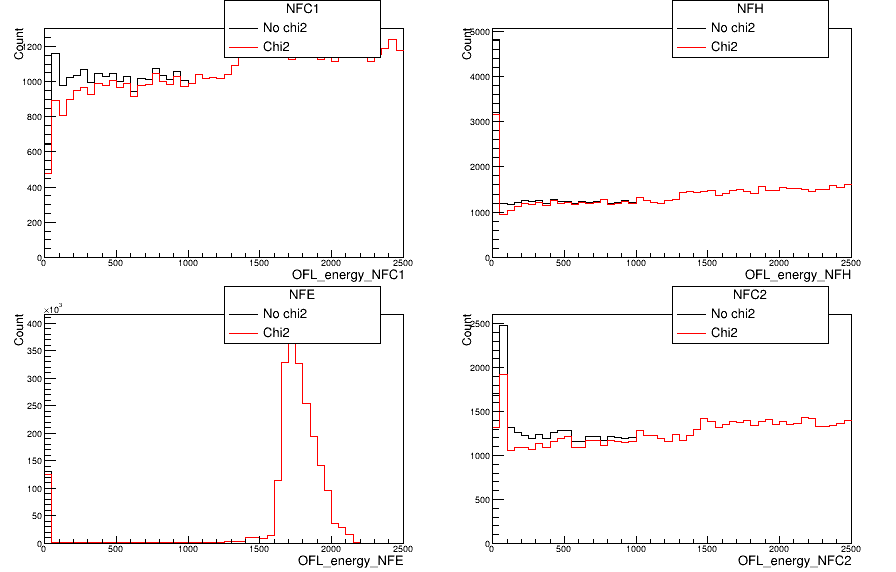

In [94]:
xaxis_label = 'OFL_energy'
yaxis_label = 'Count'
legend_spec = {}
legend_spec['header'] = ''
legend_spec['loc'] = [0.5,0.8,0.85,1]
legend_spec['ncolumn'] = 1
legend_spec[0] = 'No chi2'
legend_spec[1] = 'Chi2 '
# legend_spec[2] = 'series3'
tools.plothelper(tr,hists,setlog={'x':False,'y':False}, xaxis_label = xaxis_label,draw_option = 'NOSTACK,hist',
           yaxis_label = yaxis_label, legend_spec= legend_spec)